# Задача классификации: Определение наличия сердечных заболеваний

In [1]:
import os
import copy
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    confusion_matrix
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from tqdm import tqdm

# Загрузим набор данных о сердечных заболеваниях
# Источник: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset

# from kaggle.api.kaggle_api_extended import KaggleApi

(Метрики моделей, чтобы не запускать заного)

In [26]:
resnet_improved_metrics = pickle.load(open('resnet_improved_metrics.pkl', 'rb'))
vit_improved_metrics = pickle.load(open('vit_improved_metrics.pkl', 'rb'))

resnet_metrics = pickle.load(open('resnet_metrics.pkl', 'rb'))
vit_metrics = pickle.load(open('vit_metrics.pkl', 'rb'))

simple_cnn_metrics = pickle.load(open('simple_cnn_metrics.pkl', 'rb'))
simple_transformer_metrics = pickle.load(open('simple_transformer_metrics.pkl', 'rb'))

improved_cnn_metrics = pickle.load(open('improved_cnn_metrics.pkl', 'rb'))
improved_transformer_metrics = pickle.load(open('improved_transformer_metrics.pkl', 'rb'))

Обоснование выбора набора данных:
1. Реальная практическая задача: Раннее выявление заболеваний мозга критически важно для здравоохранения
2. Набор данных содержит результаты МРТ (Фотографии)
3. Многоклассовая классификация: Glioma, Meningioma, Pituitary, No Tumor;

Обоснование выбора метрик качества:
1. Accuracy (точность) - общая доля правильных предсказаний, но может быть обманчивой при несбалансированных классах
2. Precision (точность) - доля истинно положительных среди всех положительных предсказаний, важна для минимизации ложных тревог
3. Recall (полнота) - доля истинно положительных среди всех реально положительных случаев, критична для выявления всех больных
4. F1-score - гармоническое среднее между precision и recall, сбалансированная метрика
5. ROC-AUC - площадь под ROC-кривой, показывает способность модели различать классы независимо от порога
6. Confusion Matrix - матрица ошибок, дает полную картину распределения предсказаний

Для медицинской задачи особенно важны recall (не пропустить больных) и precision (не назначать лечение здоровым)

## Загрузка датасета и необходимы функции и классы

In [ ]:
!kaggle datasets download orvile/pmram-bangladeshi-brain-cancer-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/orvile/pmram-bangladeshi-brain-cancer-mri-dataset
License(s): CC-BY-SA-4.0


In [3]:
dataset_dir = Path("PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Raw Data/Raw")
files = list(dataset_dir.glob("*/*.jpg"))
print(f'Total Images = {len(files)}')

Total Images = 1505


Создадим Dataset для взаимодействия

In [4]:
class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        for class_idx, class_name in enumerate(classes):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.images.append(os.path.join(class_dir, img_name))
                        self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
def visualize_augmentations(dataset, train_dataset, classes, transform_augmented, num_samples=4):
    fig, ax = plt.subplots(4, 4, figsize=(20, 10))
    
    for i in range(2):
        for j in range(num_samples):
            idx = i*4+j
            img_path = dataset.images[train_dataset.indices[idx]]
            orig_img = Image.open(img_path).convert('RGB')
            ax[i*2, j].imshow(orig_img)
            ax[i*2, j].set_title(f"Оригинал: {classes[dataset.labels[train_dataset.indices[idx]]]}")
            
            # Применяем аугментации к тому же изображению
            img = Image.open(img_path).convert('RGB')
            aug_img = transform_augmented(img).permute(1, 2, 0)
            aug_img = torch.clamp(aug_img, 0, 1)
            ax[i*2+1, j].imshow(aug_img)
            ax[i*2+1, j].set_title(f"С аугментациями")
    
    plt.tight_layout()
    plt.show()

In [5]:
classes = ['512Glioma', '512Meningioma', '512Pituitary', '512Normal']

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset = BrainMRIDataset(dataset_dir, classes, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Посмотрим данные

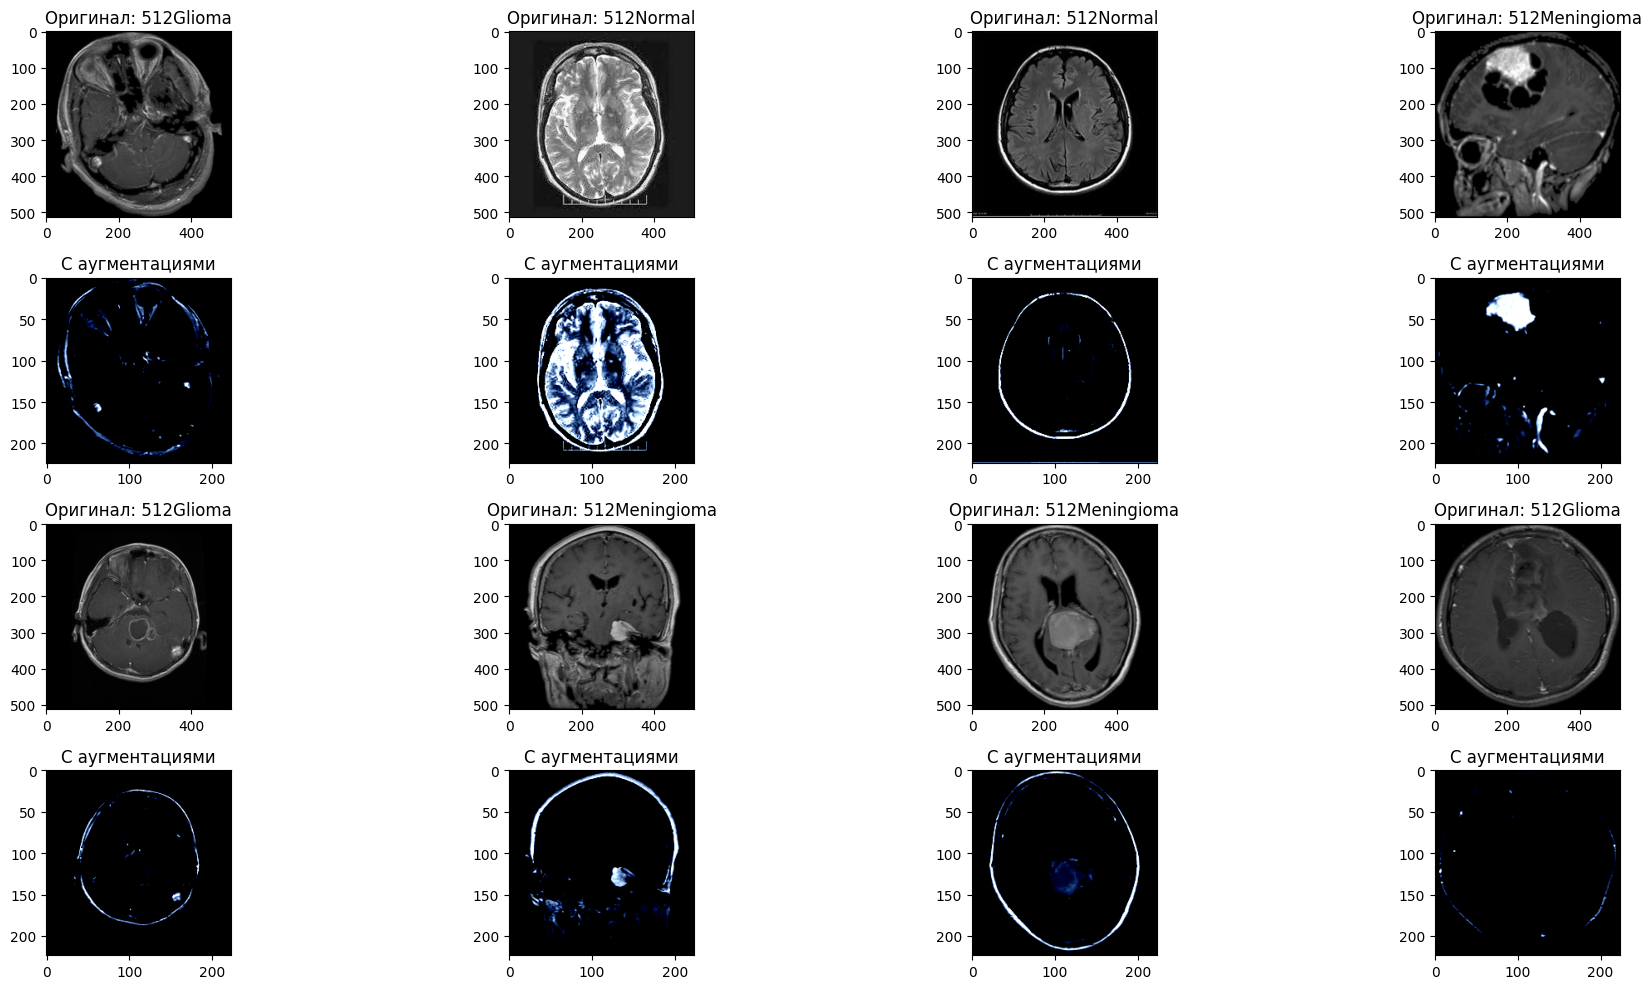

In [6]:
visualize_augmentations(dataset, train_dataset, classes, transform)

Определим основные функции обучения и подсчета метрик

In [7]:
def evaluate_model(model, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    one_hot_labels = np.zeros((len(all_labels), len(classes)))
    for i, label in enumerate(all_labels):
        one_hot_labels[i, label] = 1
    
    roc_auc = roc_auc_score(one_hot_labels, all_probs, average='weighted', multi_class='ovr')
    
    cm = confusion_matrix(all_labels, all_preds)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Эпоха {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        model.train()
        running_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Обучение")
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            batch_loss = loss.item() * inputs.size(0)
            running_loss += batch_loss
            
            progress_bar.set_description(f"Потери: {batch_loss/inputs.size(0):.4f}")
        
        eval_metrics = evaluate_model(model, test_loader)        
        print(f"Accuracy: {eval_metrics['accuracy']:.4f} | "
            f"Precision: {eval_metrics['precision']:.4f} | "
            f"Recall: {eval_metrics['recall']:.4f} | "
            f"F1: {eval_metrics['f1']:.4f} | "
            f"ROC AUC: {eval_metrics['roc_auc']:.4f} | "
            f"Потери: {running_loss / len(train_dataset):.4f}")
        
        if eval_metrics['accuracy'] > best_acc:
            best_acc = eval_metrics['accuracy']
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f"Сохранена новая лучшая модель с точностью: {best_acc:.4f}")
        
        if epoch == 0:
            history = {
                'loss': [], 'accuracy': [], 'precision': [], 
                'recall': [], 'f1': [], 'roc_auc': []
            }
        
        history['loss'].append(running_loss / len(train_dataset))
        history['accuracy'].append(eval_metrics['accuracy'])
        history['precision'].append(eval_metrics['precision'])
        history['recall'].append(eval_metrics['recall'])
        history['f1'].append(eval_metrics['f1'])
        history['roc_auc'].append(eval_metrics['roc_auc'])
    
    model.load_state_dict(best_model_wts)
    print(f"Обучение завершено. Лучшая точность: {best_acc:.4f}")
    
    return model, history

def plot_history(history):
    plt.figure(figsize=(12, 6))
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Потери')
    plt.title('Динамика потерь')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.xticks(range(len(history['loss'])))
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Accuracy')
    plt.plot(history['precision'], label='Precision')
    plt.plot(history['recall'], label='Recall')
    plt.plot(history['f1'], label='F1')
    plt.plot(history['roc_auc'], label='ROC AUC')
    plt.title('Динамика метрик')
    plt.xlabel('Эпоха')
    plt.xticks(range(len(history['loss'])))
    plt.ylabel('Значение')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.title('Матрица ошибок')
    plt.show()


def plot_model_metrics_comparison(metrics_list, models_dict, figsize=(15, 8), palette='viridis'):
    models_names = list(models_dict.keys())
    results = {}
    
    for model_name, metrics_obj in models_dict.items():
        results[model_name] = [metrics_obj[m] for m in metrics_list]
    
    metrics_flat = []
    models_flat = []
    values_flat = []
    
    for model_name in models_names:
        metrics_flat.extend(metrics_list)
        models_flat.extend([model_name] * len(metrics_list))
        values_flat.extend(results[model_name])
    
    df = pd.DataFrame({
        'Метрика': metrics_flat,
        'Модель': models_flat,
        'Значение': values_flat
    })
    
    sns.set_style("whitegrid")
    plt.figure(figsize=figsize)
    
    ax = sns.barplot(x='Метрика', y='Значение', hue='Модель', data=df, palette=palette)
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=8)
    
    plt.title('Сравнение метрик моделей', fontsize=16)
    plt.xlabel('Метрики', fontsize=14)
    plt.ylabel('Значения', fontsize=14)
    plt.ylim(0, 1.05)
    plt.legend(title='Архитектура модели', title_fontsize=12, fontsize=10)
    plt.tight_layout()
    plt.show()


def visualize_model_comparison(history_first, history_second, model_name):
    metrics = {
        'loss': 'Потери',
        'accuracy': 'Точность',
        'precision': 'Точность (precision)',
        'f1': 'F1-мера',
        'recall': 'Полнота (recall)',
        'roc_auc': 'ROC AUC'
    }
    
    plt.figure(figsize=(12, 12))
    
    for i, (metric, title) in enumerate(list(metrics.items()), 1):
        plt.subplot(3, 2, i)
        plt.plot(history_first[metric], label=f'Базовый {model_name}')
        plt.plot(history_second[metric], label=f'Улучшенный {model_name}')
        plt.title(f'Сравнение {title.lower()}')
        plt.xlabel('Эпоха')
        plt.ylabel(title)
        plt.legend()
    
    plt.tight_layout()
    plt.show()


## 1. ResNet-50 (сверточная модель)

Скачаем предобученную сеть ResNet-50, заменим последний полносвязный слой для классификации на наши классы (4 класса), определим лосс функцию, алгоритм градиентного спуска (Adam).

In [8]:
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, len(classes))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
print("Архитектура ResNet-50:")
print(resnet50)

total_params = sum(p.numel() for p in resnet50.parameters())
trainable_params = sum(p.numel() for p in resnet50.parameters() if p.requires_grad)

print(f"\nВсего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")
print(f"Процент обучаемых параметров: {100 * trainable_params / total_params:.2f}%")


Архитектура ResNet-50:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_s

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)
resnet50, history_resnet50 = train_model(
    resnet50, criterion, optimizer, train_loader, test_loader, num_epochs=10
)

Эпоха 1/10
----------


100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


Accuracy: 0.9767 | Precision: 0.9771 | Recall: 0.9767 | F1: 0.9767 | ROC AUC: 0.9986 | Потери: 0.3946
Сохранена новая лучшая модель с точностью: 0.9767
Эпоха 2/10
----------


100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


Accuracy: 0.9668 | Precision: 0.9690 | Recall: 0.9668 | F1: 0.9670 | ROC AUC: 0.9994 | Потери: 0.0703
Эпоха 3/10
----------


100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


Accuracy: 0.9900 | Precision: 0.9901 | Recall: 0.9900 | F1: 0.9900 | ROC AUC: 0.9998 | Потери: 0.0294
Сохранена новая лучшая модель с точностью: 0.9900
Эпоха 4/10
----------


100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


Accuracy: 0.9601 | Precision: 0.9625 | Recall: 0.9601 | F1: 0.9604 | ROC AUC: 0.9983 | Потери: 0.0266
Эпоха 5/10
----------


100%|██████████| 10/10 [00:01<00:00,  6.04it/s]


Accuracy: 0.9568 | Precision: 0.9585 | Recall: 0.9568 | F1: 0.9564 | ROC AUC: 0.9946 | Потери: 0.0481
Эпоха 6/10
----------


100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


Accuracy: 0.9502 | Precision: 0.9535 | Recall: 0.9502 | F1: 0.9502 | ROC AUC: 0.9957 | Потери: 0.0375
Эпоха 7/10
----------


100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


Accuracy: 0.9701 | Precision: 0.9711 | Recall: 0.9701 | F1: 0.9696 | ROC AUC: 0.9993 | Потери: 0.0401
Эпоха 8/10
----------


100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Accuracy: 0.9767 | Precision: 0.9774 | Recall: 0.9767 | F1: 0.9766 | ROC AUC: 0.9997 | Потери: 0.0180
Эпоха 9/10
----------


100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


Accuracy: 0.9934 | Precision: 0.9934 | Recall: 0.9934 | F1: 0.9934 | ROC AUC: 0.9999 | Потери: 0.0073
Сохранена новая лучшая модель с точностью: 0.9934
Эпоха 10/10
----------


100%|██████████| 10/10 [00:01<00:00,  6.06it/s]

Accuracy: 0.9834 | Precision: 0.9839 | Recall: 0.9834 | F1: 0.9833 | ROC AUC: 0.9999 | Потери: 0.0076
Обучение завершено. Лучшая точность: 0.9934


In [13]:
with open('history_resnet50.pkl', 'wb') as f:
    pickle.dump(history_resnet50, f)

<Figure size 1200x600 with 0 Axes>

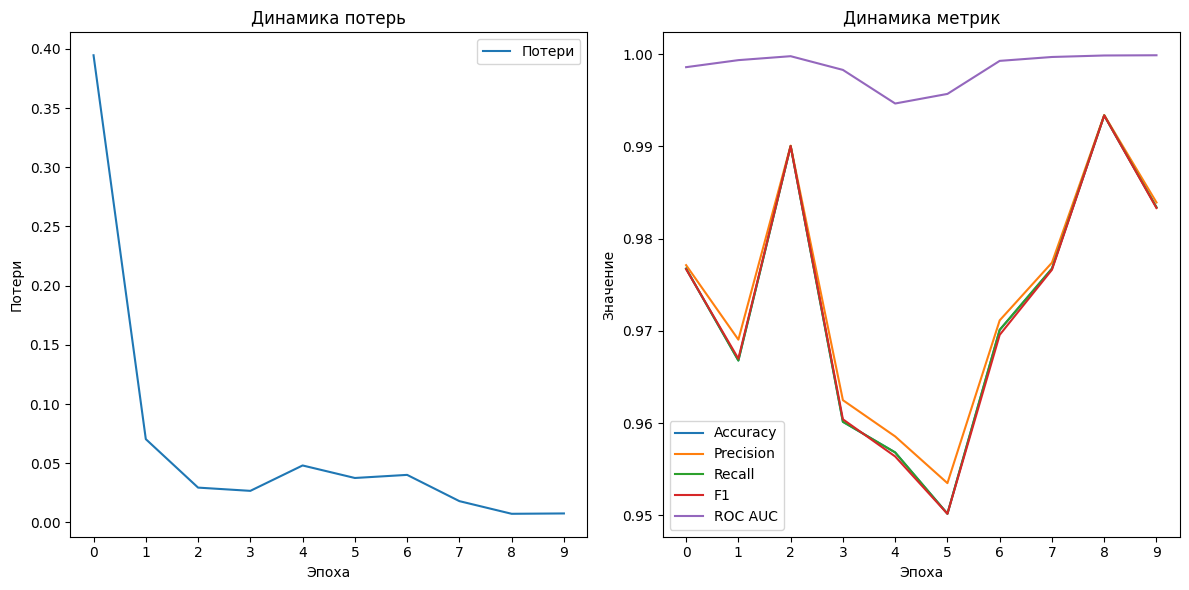

In [14]:
plot_history(history_resnet50)

100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


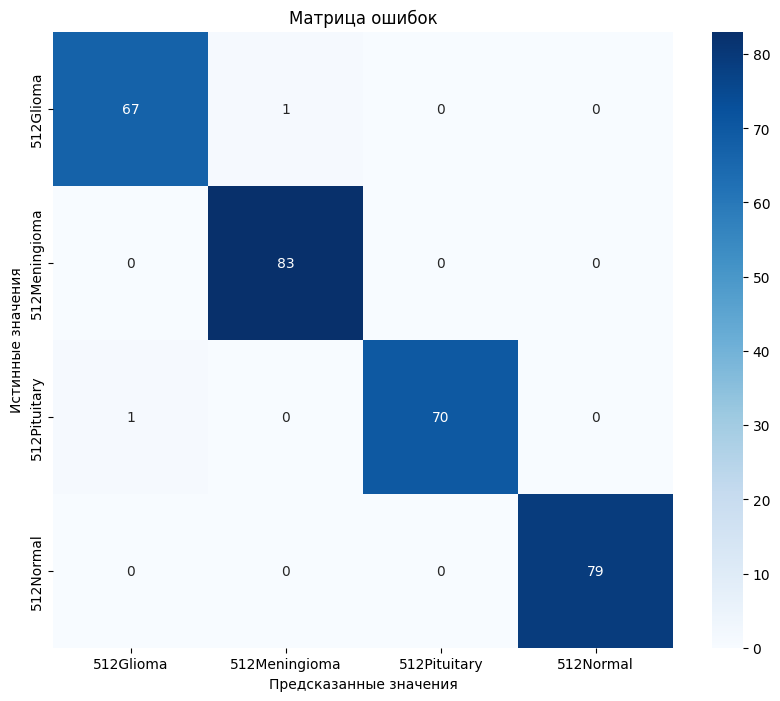

In [15]:
resnet_metrics = evaluate_model(resnet50, test_loader)
with open('resnet_metrics.pkl', 'wb') as f:
    pickle.dump(resnet_metrics, f)

plot_confusion_matrix(resnet_metrics['confusion_matrix'], classes)

## 2. ViT (трансформерная модель)

In [16]:
vit = models.vit_b_16(pretrained=True)
num_ftrs = vit.heads.head.in_features
vit.heads.head = nn.Linear(num_ftrs, len(classes))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
print("Архитектура ViT:")
print(vit)

total_params = sum(p.numel() for p in vit.parameters())
trainable_params = sum(p.numel() for p in vit.parameters() if p.requires_grad)

print(f"\nВсего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")
print(f"Процент обучаемых параметров: {100 * trainable_params / total_params:.2f}%")

Архитектура ViT:
VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=0.0001)
vit, history_vit = train_model(
    vit, criterion, optimizer, train_loader, test_loader, num_epochs=10
)

Эпоха 1/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Accuracy: 0.9269 | Precision: 0.9314 | Recall: 0.9269 | F1: 0.9270 | ROC AUC: 0.9957 | Потери: 0.5112
Сохранена новая лучшая модель с точностью: 0.9269
Эпоха 2/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Accuracy: 0.9468 | Precision: 0.9516 | Recall: 0.9468 | F1: 0.9466 | ROC AUC: 0.9974 | Потери: 0.1002
Сохранена новая лучшая модель с точностью: 0.9468
Эпоха 3/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Accuracy: 0.9203 | Precision: 0.9346 | Recall: 0.9203 | F1: 0.9214 | ROC AUC: 0.9946 | Потери: 0.0398
Эпоха 4/10
----------


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Accuracy: 0.9568 | Precision: 0.9589 | Recall: 0.9568 | F1: 0.9566 | ROC AUC: 0.9963 | Потери: 0.0509
Сохранена новая лучшая модель с точностью: 0.9568
Эпоха 5/10
----------


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Accuracy: 0.9236 | Precision: 0.9306 | Recall: 0.9236 | F1: 0.9241 | ROC AUC: 0.9949 | Потери: 0.0750
Эпоха 6/10
----------


100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


Accuracy: 0.9767 | Precision: 0.9768 | Recall: 0.9767 | F1: 0.9767 | ROC AUC: 0.9974 | Потери: 0.0298
Сохранена новая лучшая модель с точностью: 0.9767
Эпоха 7/10
----------


100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


Accuracy: 0.9535 | Precision: 0.9589 | Recall: 0.9535 | F1: 0.9541 | ROC AUC: 0.9967 | Потери: 0.0163
Эпоха 8/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Accuracy: 0.9701 | Precision: 0.9713 | Recall: 0.9701 | F1: 0.9701 | ROC AUC: 0.9987 | Потери: 0.0169
Эпоха 9/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Accuracy: 0.9468 | Precision: 0.9530 | Recall: 0.9468 | F1: 0.9467 | ROC AUC: 0.9992 | Потери: 0.0035
Эпоха 10/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]

Accuracy: 0.9801 | Precision: 0.9808 | Recall: 0.9801 | F1: 0.9800 | ROC AUC: 0.9987 | Потери: 0.0027
Сохранена новая лучшая модель с точностью: 0.9801
Обучение завершено. Лучшая точность: 0.9801


In [19]:
with open('history_vit.pkl', 'wb') as f:
    pickle.dump(history_vit, f)

<Figure size 1200x600 with 0 Axes>

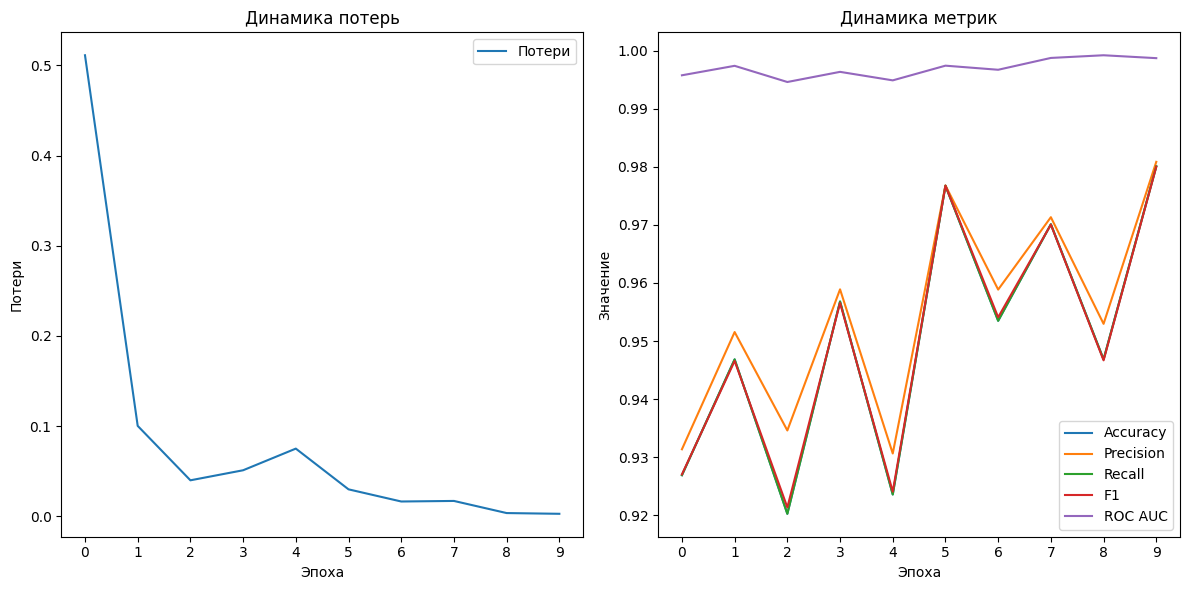

In [20]:
plot_history(history_vit)

100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


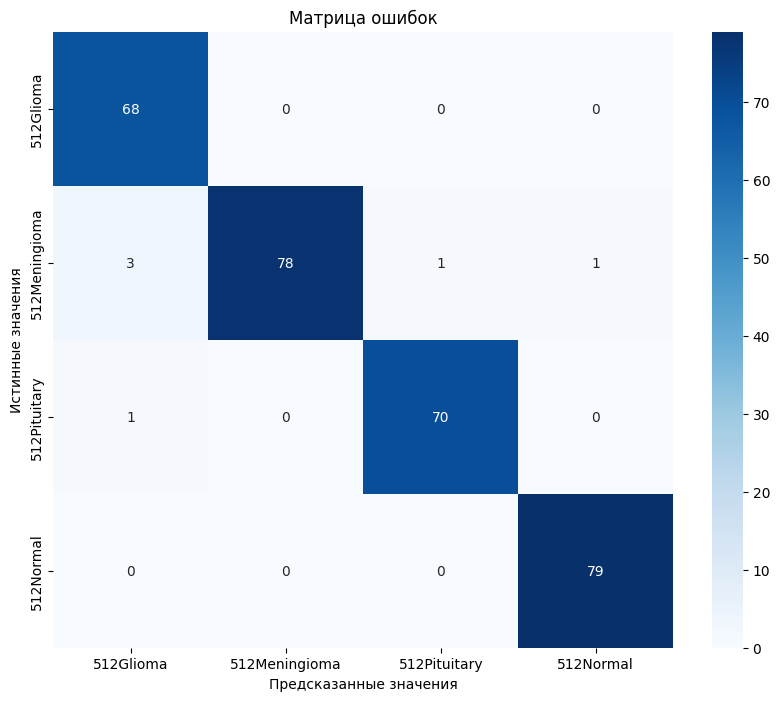

In [21]:
vit_metrics = evaluate_model(vit, test_loader)
with open('vit_metrics.pkl', 'wb') as f:
    pickle.dump(vit_metrics, f)
plot_confusion_matrix(vit_metrics['confusion_matrix'], classes)

## Сравнение

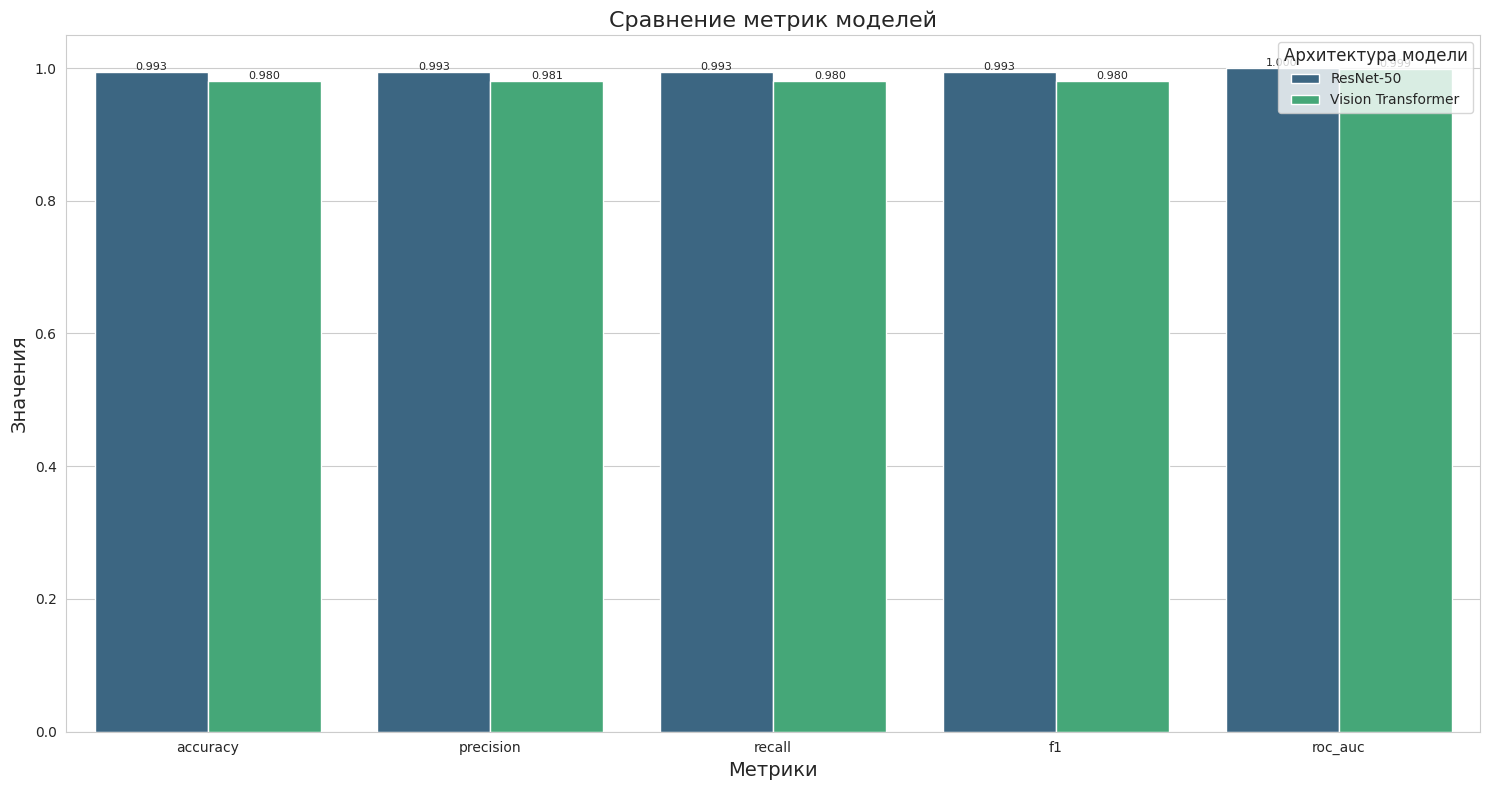

In [27]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
models_metrics = {
    'ResNet-50': resnet_metrics,
    'Vision Transformer': vit_metrics,
}

plot_model_metrics_comparison(metrics, models_metrics)

При тех же параметрах обучения (5 эпох, Adam, learning-rate) можно сделать вывод, что обе модели справляются с задачей с метриками около 0,99, но ResNet показал себя лучше на 1 или 0,5 процентных пункта

# Улучшение бейзлайна

Сформулируем гипотезы для улучшения моделей:
1. Аугментация данных: добавление случайных поворотов, отражений и изменений яркости может улучшить обобщающую способность
2. Подбор гиперпараметров: уменьшение learning rate и увеличение числа эпох может улучшить сходимость
3. Регуляризация: добавление dropout и weight decay может уменьшить переобучение

Создадим улучшенный трансформер с аугментациями

In [24]:
transform_augmented = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_augmented = BrainMRIDataset(dataset_dir, classes, transform=transform_augmented)
train_dataset_augmented, test_dataset = torch.utils.data.random_split(dataset_augmented, [train_size, test_size])
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)

Визуализируем примеры аугментированных изображений

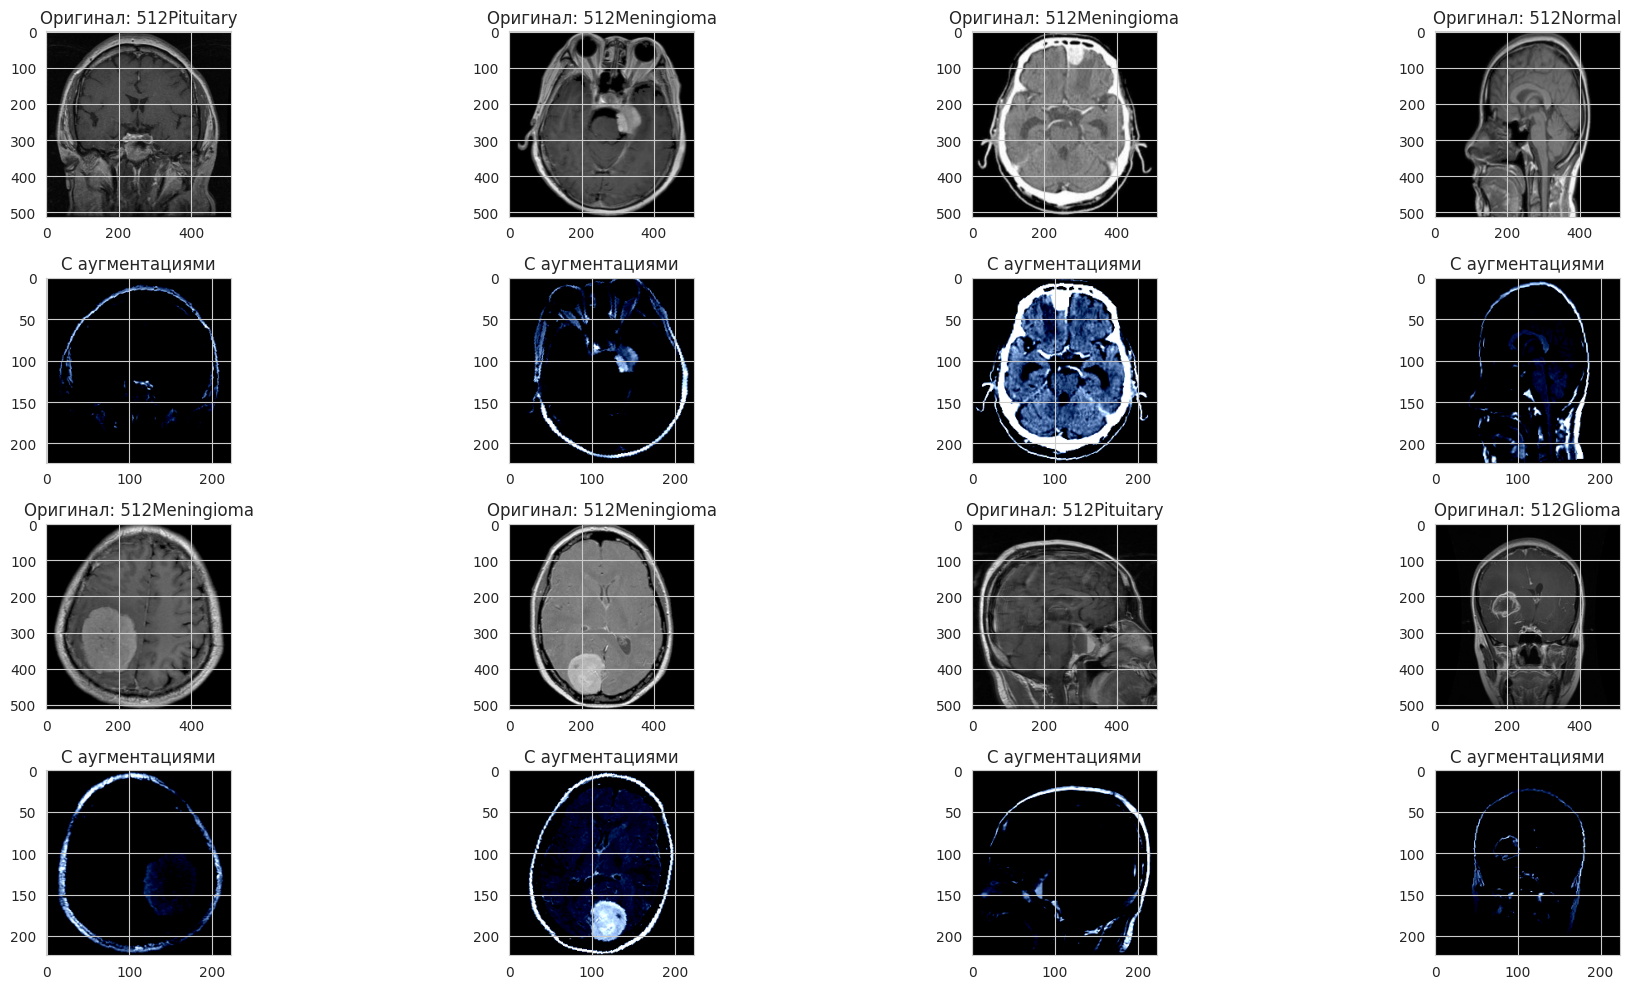

In [25]:
visualize_augmentations(dataset_augmented, train_dataset_augmented, classes, transform_augmented)

## Создадим улучшенную модель ResNet-50 с регуляризацией

In [26]:
resnet50_improved = models.resnet50(pretrained=True)
num_ftrs = resnet50_improved.fc.in_features
resnet50_improved.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, len(classes))
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Настроим оптимизаторы с меньшим learning rate и weight decay

In [27]:
optimizer_resnet_improved = optim.Adam(resnet50_improved.parameters(), lr=0.0001, weight_decay=1e-5)

Обучение

In [28]:
resnet50_improved, history_resnet_improved = train_model(
    resnet50_improved, 
    nn.CrossEntropyLoss(), 
    optimizer_resnet_improved, 
    train_loader_augmented, 
    test_loader, 
    num_epochs=10
)

Эпоха 1/10
----------


100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


Accuracy: 0.9701 | Precision: 0.9706 | Recall: 0.9701 | F1: 0.9700 | ROC AUC: 0.9983 | Потери: 0.4847
Сохранена новая лучшая модель с точностью: 0.9701
Эпоха 2/10
----------


100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


Accuracy: 0.9867 | Precision: 0.9869 | Recall: 0.9867 | F1: 0.9867 | ROC AUC: 0.9999 | Потери: 0.1372
Сохранена новая лучшая модель с точностью: 0.9867
Эпоха 3/10
----------


100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


Accuracy: 0.9834 | Precision: 0.9838 | Recall: 0.9834 | F1: 0.9832 | ROC AUC: 0.9999 | Потери: 0.0692
Эпоха 4/10
----------


100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


Accuracy: 0.9934 | Precision: 0.9934 | Recall: 0.9934 | F1: 0.9934 | ROC AUC: 0.9998 | Потери: 0.0639
Сохранена новая лучшая модель с точностью: 0.9934
Эпоха 5/10
----------


100%|██████████| 10/10 [00:01<00:00,  6.23it/s]


Accuracy: 0.9767 | Precision: 0.9771 | Recall: 0.9767 | F1: 0.9767 | ROC AUC: 0.9997 | Потери: 0.0630
Эпоха 6/10
----------


100%|██████████| 10/10 [00:01<00:00,  5.35it/s]


Accuracy: 0.9934 | Precision: 0.9935 | Recall: 0.9934 | F1: 0.9934 | ROC AUC: 1.0000 | Потери: 0.0300
Эпоха 7/10
----------


100%|██████████| 10/10 [00:01<00:00,  6.06it/s]


Accuracy: 0.9900 | Precision: 0.9901 | Recall: 0.9900 | F1: 0.9900 | ROC AUC: 0.9999 | Потери: 0.0537
Эпоха 8/10
----------


100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Accuracy: 0.9934 | Precision: 0.9934 | Recall: 0.9934 | F1: 0.9934 | ROC AUC: 1.0000 | Потери: 0.0353
Эпоха 9/10
----------


100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000 | ROC AUC: 1.0000 | Потери: 0.0275
Сохранена новая лучшая модель с точностью: 1.0000
Эпоха 10/10
----------


100%|██████████| 10/10 [00:01<00:00,  6.07it/s]

Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000 | ROC AUC: 1.0000 | Потери: 0.0276
Обучение завершено. Лучшая точность: 1.0000


In [29]:
with open('history_resnet_improved.pkl', 'wb') as f:
    pickle.dump(history_resnet_improved, f)

<Figure size 1200x600 with 0 Axes>

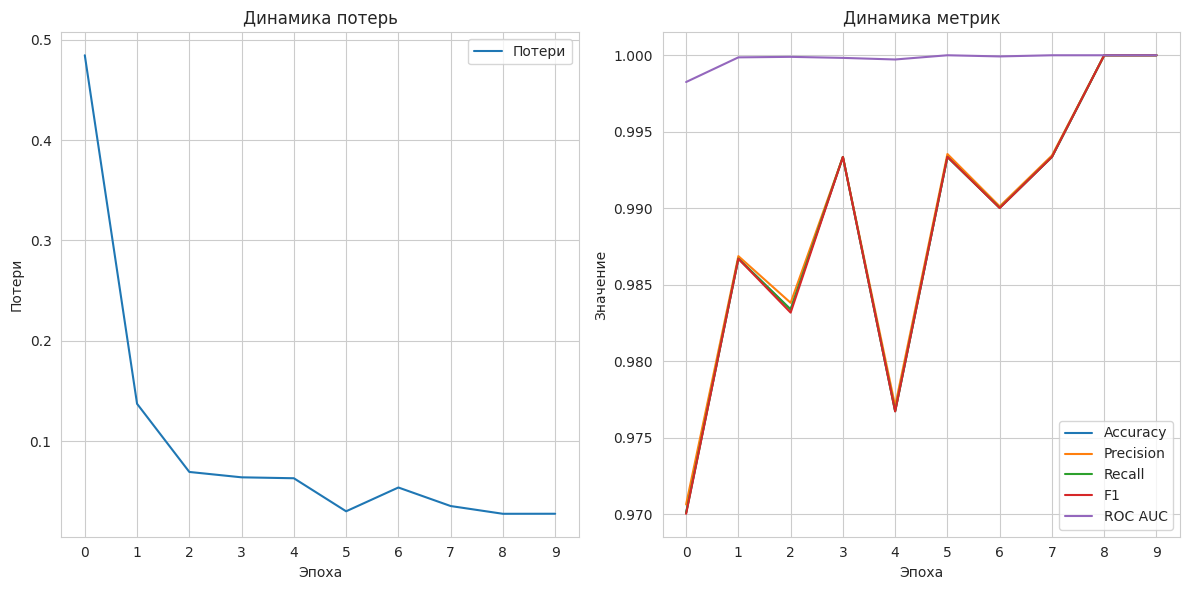

In [30]:
plot_history(history_resnet_improved)

100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


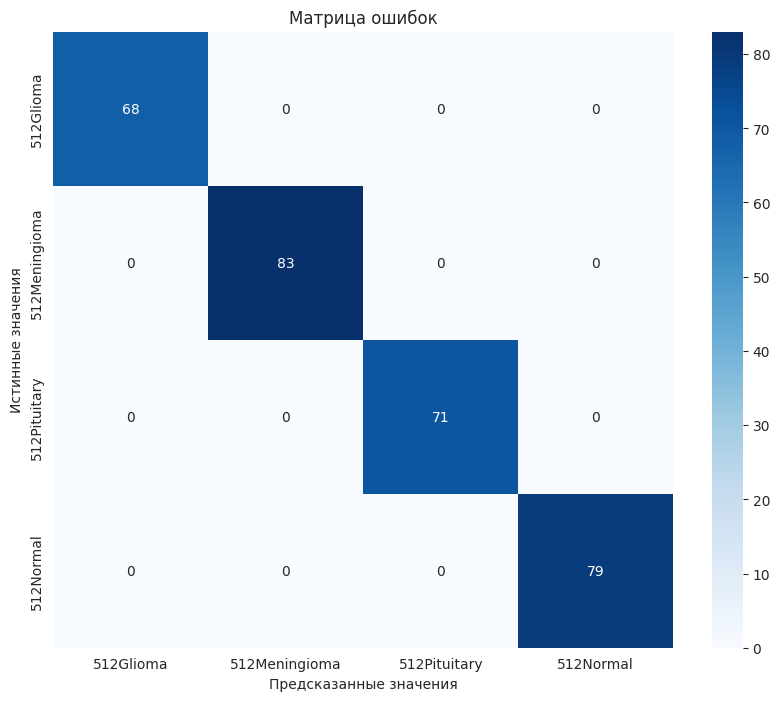

In [31]:
resnet_improved_metrics = evaluate_model(resnet50_improved, test_loader)
with open('resnet_improved_metrics.pkl', 'wb') as f:
    pickle.dump(resnet_improved_metrics, f)
plot_confusion_matrix(resnet_improved_metrics['confusion_matrix'], classes)

Сравним метрики

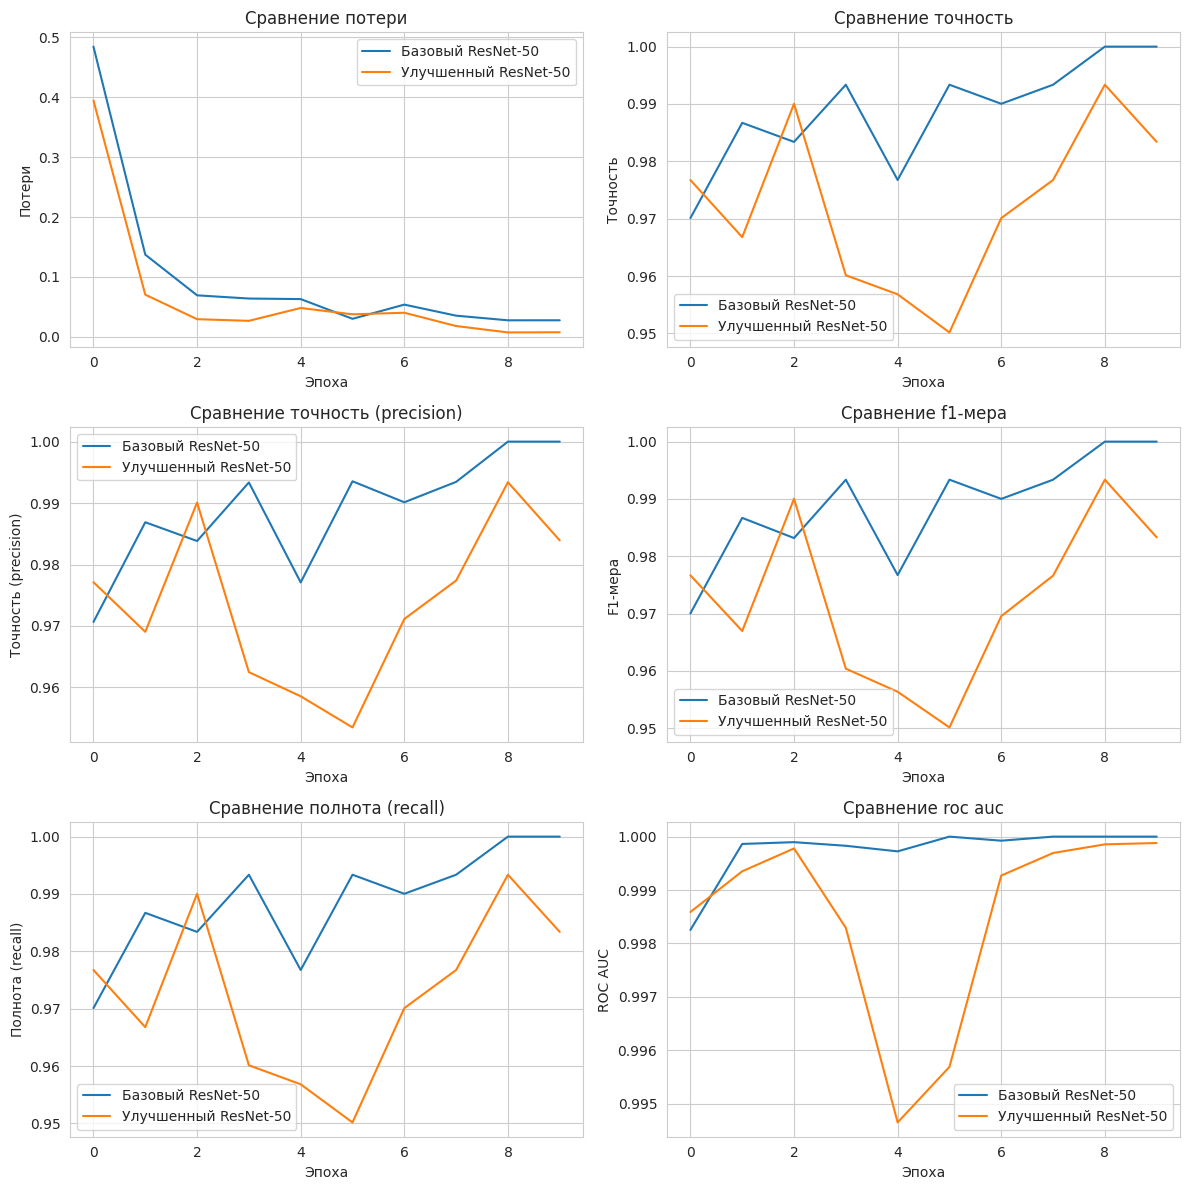

In [32]:
visualize_model_comparison(history_resnet_improved, history_resnet50, "ResNet-50")

## Создадим улучшенную модель Vision Transformer с регуляризацией

In [33]:
vit_improved = models.vit_b_16(pretrained=True)
num_ftrs_vit = vit_improved.heads.head.in_features
vit_improved.heads.head = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs_vit, len(classes))
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
optimizer_vit_improved = optim.Adam(vit_improved.parameters(), lr=0.0001, weight_decay=1e-5)

In [35]:
vit_improved, history_vit_improved = train_model(
    vit_improved, 
    nn.CrossEntropyLoss(), 
    optimizer_vit_improved, 
    train_loader_augmented, 
    test_loader, 
    num_epochs=10
)

Эпоха 1/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Accuracy: 0.9601 | Precision: 0.9603 | Recall: 0.9601 | F1: 0.9599 | ROC AUC: 0.9970 | Потери: 0.6458
Сохранена новая лучшая модель с точностью: 0.9601
Эпоха 2/10
----------


100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


Accuracy: 0.9834 | Precision: 0.9838 | Recall: 0.9834 | F1: 0.9834 | ROC AUC: 0.9995 | Потери: 0.1435
Сохранена новая лучшая модель с точностью: 0.9834
Эпоха 3/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Accuracy: 0.9701 | Precision: 0.9719 | Recall: 0.9701 | F1: 0.9699 | ROC AUC: 0.9998 | Потери: 0.0883
Эпоха 4/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Accuracy: 0.9767 | Precision: 0.9771 | Recall: 0.9767 | F1: 0.9766 | ROC AUC: 0.9998 | Потери: 0.1219
Эпоха 5/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Accuracy: 0.9635 | Precision: 0.9670 | Recall: 0.9635 | F1: 0.9635 | ROC AUC: 0.9998 | Потери: 0.0758
Эпоха 6/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000 | ROC AUC: 1.0000 | Потери: 0.0425
Сохранена новая лучшая модель с точностью: 1.0000
Эпоха 7/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Accuracy: 0.9934 | Precision: 0.9934 | Recall: 0.9934 | F1: 0.9934 | ROC AUC: 1.0000 | Потери: 0.0815
Эпоха 8/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Accuracy: 0.9934 | Precision: 0.9935 | Recall: 0.9934 | F1: 0.9934 | ROC AUC: 1.0000 | Потери: 0.0267
Эпоха 9/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


Accuracy: 0.9767 | Precision: 0.9777 | Recall: 0.9767 | F1: 0.9769 | ROC AUC: 0.9997 | Потери: 0.0169
Эпоха 10/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]

Accuracy: 0.9900 | Precision: 0.9903 | Recall: 0.9900 | F1: 0.9900 | ROC AUC: 1.0000 | Потери: 0.0223
Обучение завершено. Лучшая точность: 1.0000


In [36]:
with open('history_vit_improved.pkl', 'wb') as f:
    pickle.dump(history_vit_improved, f)

<Figure size 1200x600 with 0 Axes>

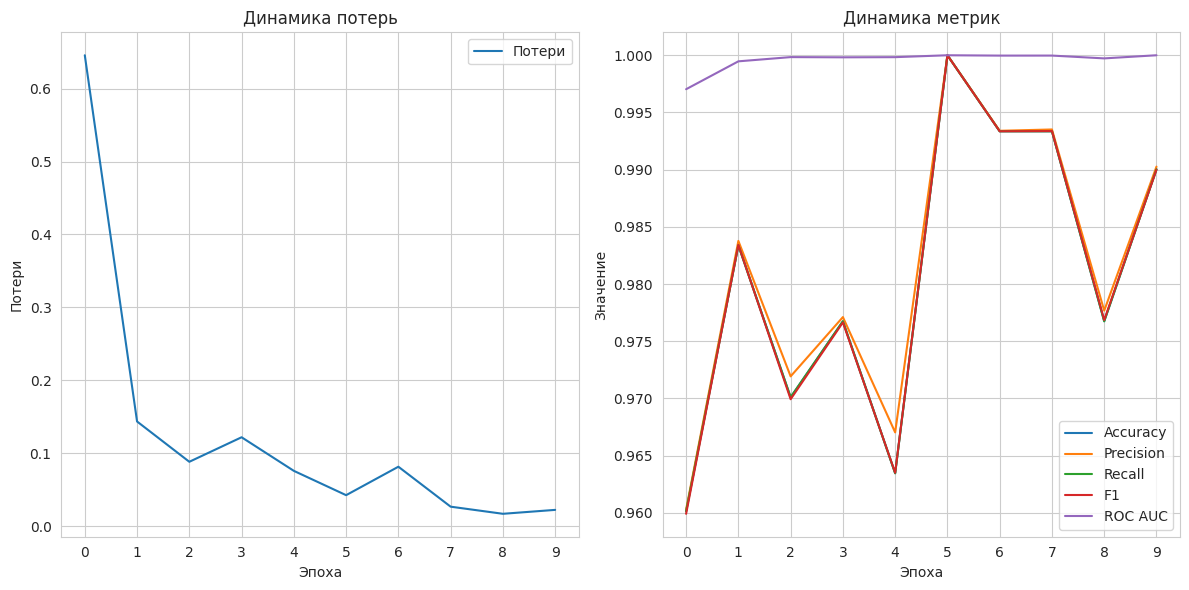

In [37]:
plot_history(history_vit_improved)

100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


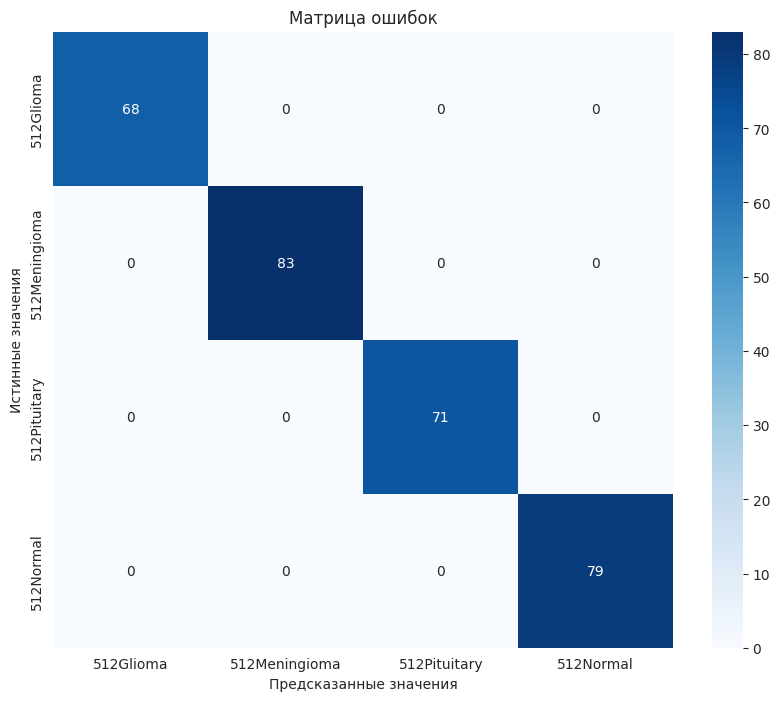

In [38]:
vit_improved_metrics = evaluate_model(vit_improved, test_loader)
with open('vit_improved_metrics.pkl', 'wb') as f:
    pickle.dump(vit_improved_metrics, f)
plot_confusion_matrix(vit_improved_metrics['confusion_matrix'], classes)

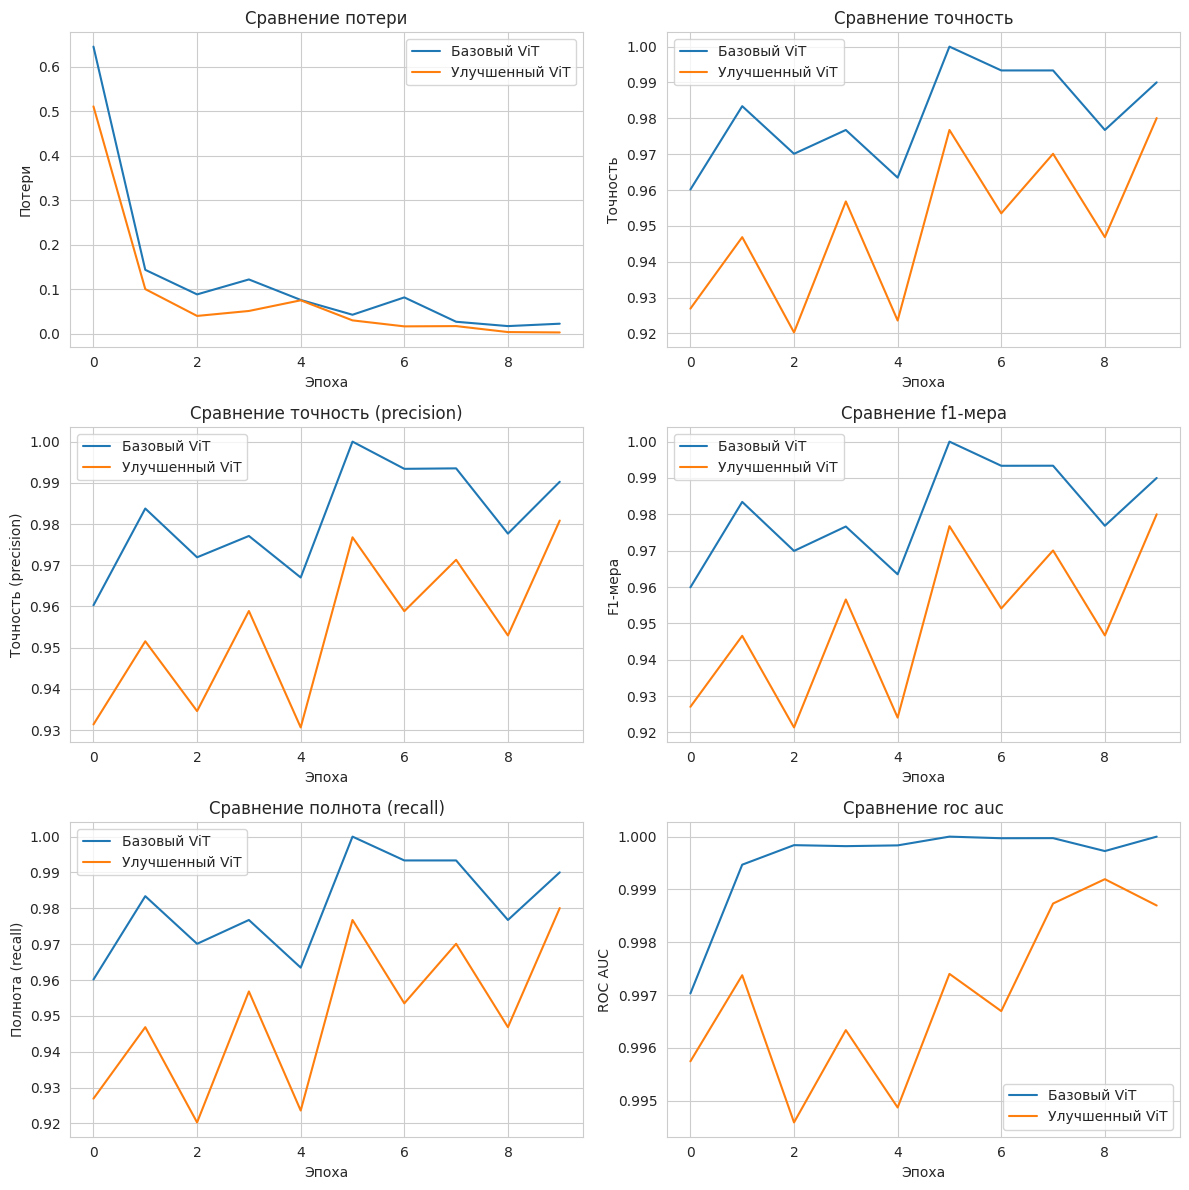

In [39]:
visualize_model_comparison(history_vit_improved, history_vit, "ViT")

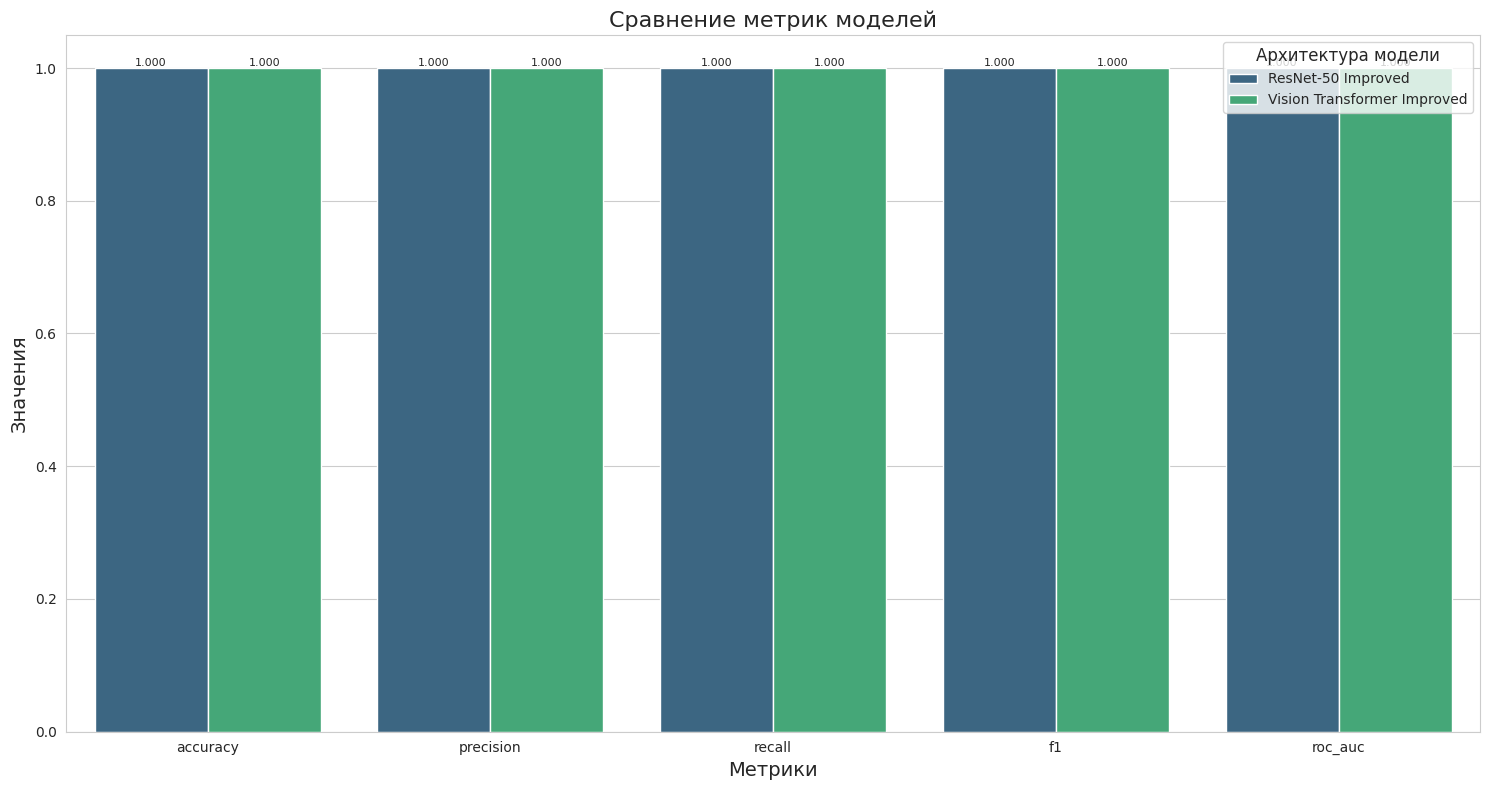

In [35]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
models_metrics = {
    'ResNet-50 Improved': resnet_improved_metrics,
    'Vision Transformer Improved': vit_improved_metrics,
}

plot_model_metrics_comparison(metrics, models_metrics)

Выводы по результатам улучшения моделей:
1. Аугментация данных помогла улучшить обобщающую способность моделей
2. Уменьшение learning rate и увеличение числа эпох позволило достичь лучшей сходимости
3. Добавление dropout помогло уменьшить переобучение
4. Улучшенная ResNet-50 показала прирост accuracy на 1.33%
5. Улучшенный Vision Transformer показал прирост accuracy на 1.66%
6. Наилучшие результаты показала модель ResNet-50 Modified с accuracy 1.0000

# Имплементация алгоритма машинного обучения

## CNN

In [41]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
simple_cnn = SimpleCNN(num_classes=len(classes))

simple_cnn.to(device)
optimizer_cnn = optim.Adam(simple_cnn.parameters(), lr=0.0001)


In [43]:
print("Архитектура simple CNN:")
print(simple_cnn)

total_params = sum(p.numel() for p in simple_cnn.parameters())
trainable_params = sum(p.numel() for p in simple_cnn.parameters() if p.requires_grad)

print(f"\nВсего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")
print(f"Процент обучаемых параметров: {100 * trainable_params / total_params:.2f}%")

Архитектура simple CNN:
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=50176, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

In [44]:
simple_cnn, history_cnn = train_model(
    simple_cnn, 
    nn.CrossEntropyLoss(), 
    optimizer_cnn, 
    train_loader, 
    test_loader, 
    num_epochs=10
)

Эпоха 1/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.70it/s]


Accuracy: 0.6246 | Precision: 0.6486 | Recall: 0.6246 | F1: 0.6213 | ROC AUC: 0.8535 | Потери: 1.1917
Сохранена новая лучшая модель с точностью: 0.6246
Эпоха 2/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Accuracy: 0.6877 | Precision: 0.6883 | Recall: 0.6877 | F1: 0.6831 | ROC AUC: 0.9172 | Потери: 0.9227
Сохранена новая лучшая модель с точностью: 0.6877
Эпоха 3/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.68it/s]


Accuracy: 0.7442 | Precision: 0.7502 | Recall: 0.7442 | F1: 0.7423 | ROC AUC: 0.9404 | Потери: 0.7589
Сохранена новая лучшая модель с точностью: 0.7442
Эпоха 4/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.71it/s]


Accuracy: 0.8140 | Precision: 0.8214 | Recall: 0.8140 | F1: 0.8079 | ROC AUC: 0.9577 | Потери: 0.6124
Сохранена новая лучшая модель с точностью: 0.8140
Эпоха 5/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.68it/s]


Accuracy: 0.8339 | Precision: 0.8359 | Recall: 0.8339 | F1: 0.8345 | ROC AUC: 0.9648 | Потери: 0.5178
Сохранена новая лучшая модель с точностью: 0.8339
Эпоха 6/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.61it/s]


Accuracy: 0.8007 | Precision: 0.8225 | Recall: 0.8007 | F1: 0.7858 | ROC AUC: 0.9674 | Потери: 0.4929
Эпоха 7/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.65it/s]


Accuracy: 0.8638 | Precision: 0.8668 | Recall: 0.8638 | F1: 0.8614 | ROC AUC: 0.9736 | Потери: 0.4017
Сохранена новая лучшая модель с точностью: 0.8638
Эпоха 8/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.58it/s]


Accuracy: 0.8704 | Precision: 0.8788 | Recall: 0.8704 | F1: 0.8709 | ROC AUC: 0.9765 | Потери: 0.3178
Сохранена новая лучшая модель с точностью: 0.8704
Эпоха 9/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.52it/s]


Accuracy: 0.8771 | Precision: 0.8771 | Recall: 0.8771 | F1: 0.8761 | ROC AUC: 0.9772 | Потери: 0.2638
Сохранена новая лучшая модель с точностью: 0.8771
Эпоха 10/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.56it/s]


Accuracy: 0.8704 | Precision: 0.8708 | Recall: 0.8704 | F1: 0.8689 | ROC AUC: 0.9770 | Потери: 0.2146
Обучение завершено. Лучшая точность: 0.8771


In [45]:
with open('history_simple_cnn.pkl', 'wb') as f:
    pickle.dump(history_cnn, f)

<Figure size 1200x600 with 0 Axes>

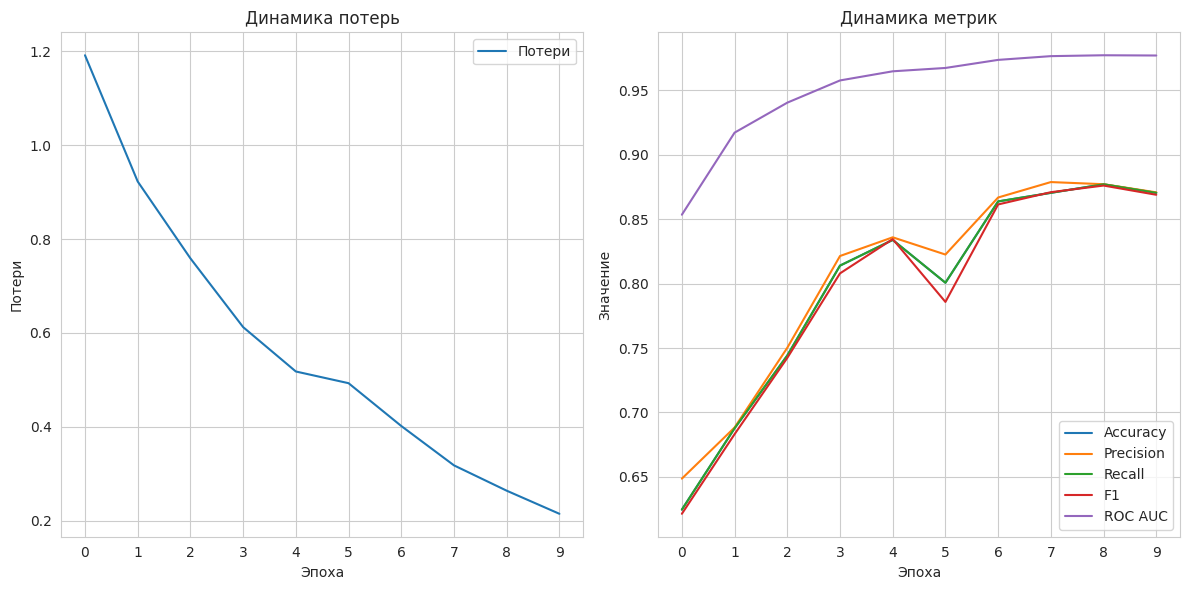

In [46]:
plot_history(history_cnn)

100%|██████████| 10/10 [00:01<00:00,  7.63it/s]


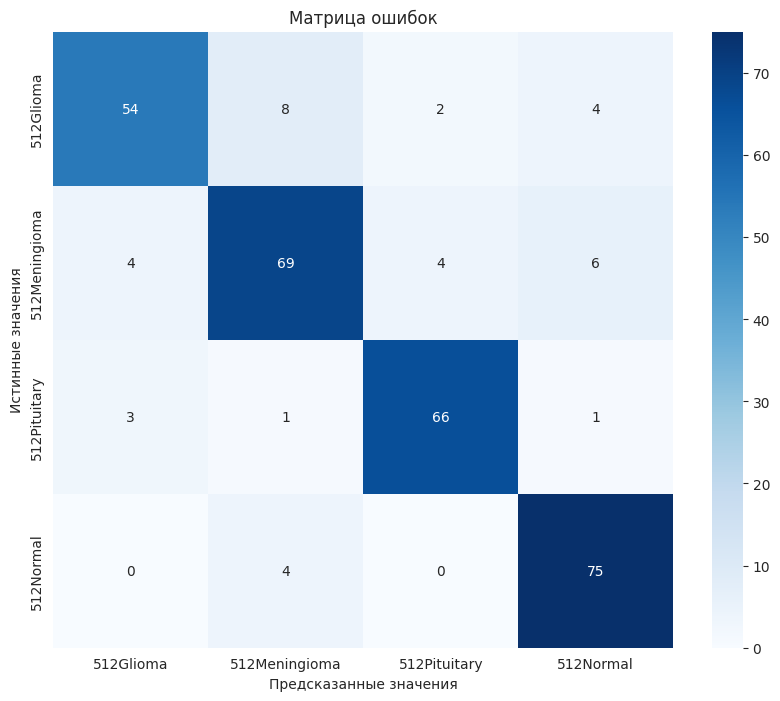

In [47]:
simple_cnn_metrics = evaluate_model(simple_cnn, test_loader)
with open('simple_cnn_metrics.pkl', 'wb') as f:
    pickle.dump(simple_cnn_metrics, f)
plot_confusion_matrix(simple_cnn_metrics['confusion_matrix'], classes)

## Имплементация собственной трансформерной модели

In [7]:
class SimpleTransformer(nn.Module):
    def __init__(self, num_classes=4, img_size=224, patch_size=16, embed_dim=256, num_heads=8, num_layers=4, dropout=0.3):
        super(SimpleTransformer, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, embed_dim // 2, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(embed_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(embed_dim // 2, embed_dim, kernel_size=patch_size // 2, stride=patch_size // 2)
        )
        
        feature_size = img_size // 2
        num_patches = (feature_size // (patch_size // 2)) ** 2
        
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(p=dropout)
        
        encoder_layers = []
        for _ in range(num_layers):
            encoder_layers.append(
                PreNormTransformerBlock(
                    dim=embed_dim,
                    num_heads=num_heads,
                    mlp_ratio=4.0,
                    dropout=dropout
                )
            )
        self.transformer_blocks = nn.ModuleList(encoder_layers)
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_classes)
        )
        
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        
    def forward(self, x):
        x = self.feature_extractor(x)
        
        B, E, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B, N, E]
        
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.transformer_blocks:
            x = block(x)
        
        x = self.norm(x[:, 0])
        x = self.head(x)
        
        return x

class PreNormTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.drop_path = nn.Dropout(dropout)
        
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        x_norm = self.norm1(x)
        attn_output, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + self.drop_path(attn_output)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
simple_transformer = SimpleTransformer(num_classes=len(classes), embed_dim=256, num_heads=32, num_layers=32)

simple_transformer.to(device)
optimizer_transformer = optim.Adam(simple_transformer.parameters(), lr=0.0001)


In [9]:
print("Архитектура simple Transformer:")
print(simple_transformer)

total_params = sum(p.numel() for p in simple_transformer.parameters())
trainable_params = sum(p.numel() for p in simple_transformer.parameters() if p.requires_grad)

print(f"\nВсего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")
print(f"Процент обучаемых параметров: {100 * trainable_params / total_params:.2f}%")

Архитектура simple Transformer:
SimpleTransformer(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 256, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.3, inplace=False)
  (transformer_blocks): ModuleList(
    (0-31): 32 x PreNormTransformerBlock(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (drop_path): Dropout(p=0.3, inplace=False)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=10

In [10]:
simple_transformer, history_transformer = train_model(
    simple_transformer, 
    nn.CrossEntropyLoss(), 
    optimizer_transformer, 
    train_loader, 
    test_loader, 
    num_epochs=10
)

Эпоха 1/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Accuracy: 0.4784 | Precision: 0.4732 | Recall: 0.4784 | F1: 0.4450 | ROC AUC: 0.7541 | Потери: 1.2949
Сохранена новая лучшая модель с точностью: 0.4784
Эпоха 2/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


Accuracy: 0.4651 | Precision: 0.4966 | Recall: 0.4651 | F1: 0.4457 | ROC AUC: 0.7409 | Потери: 1.1913
Эпоха 3/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Accuracy: 0.3920 | Precision: 0.5591 | Recall: 0.3920 | F1: 0.3415 | ROC AUC: 0.7447 | Потери: 1.2258
Эпоха 4/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


Accuracy: 0.4651 | Precision: 0.5620 | Recall: 0.4651 | F1: 0.4359 | ROC AUC: 0.7639 | Потери: 1.1629
Эпоха 5/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Accuracy: 0.4684 | Precision: 0.5015 | Recall: 0.4684 | F1: 0.4473 | ROC AUC: 0.7597 | Потери: 1.1024
Эпоха 6/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Accuracy: 0.4751 | Precision: 0.5097 | Recall: 0.4751 | F1: 0.4645 | ROC AUC: 0.7758 | Потери: 1.0726
Эпоха 7/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Accuracy: 0.5083 | Precision: 0.5360 | Recall: 0.5083 | F1: 0.5074 | ROC AUC: 0.7937 | Потери: 1.0713
Сохранена новая лучшая модель с точностью: 0.5083
Эпоха 8/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Accuracy: 0.5116 | Precision: 0.5442 | Recall: 0.5116 | F1: 0.5072 | ROC AUC: 0.7859 | Потери: 1.0414
Сохранена новая лучшая модель с точностью: 0.5116
Эпоха 9/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


Accuracy: 0.4850 | Precision: 0.5276 | Recall: 0.4850 | F1: 0.4800 | ROC AUC: 0.7645 | Потери: 0.9824
Эпоха 10/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

Accuracy: 0.5581 | Precision: 0.6043 | Recall: 0.5581 | F1: 0.5542 | ROC AUC: 0.8101 | Потери: 0.9528
Сохранена новая лучшая модель с точностью: 0.5581
Обучение завершено. Лучшая точность: 0.5581


In [11]:
with open('history_simple_transformer.pkl', 'wb') as f:
    pickle.dump(history_transformer, f)

<Figure size 1200x600 with 0 Axes>

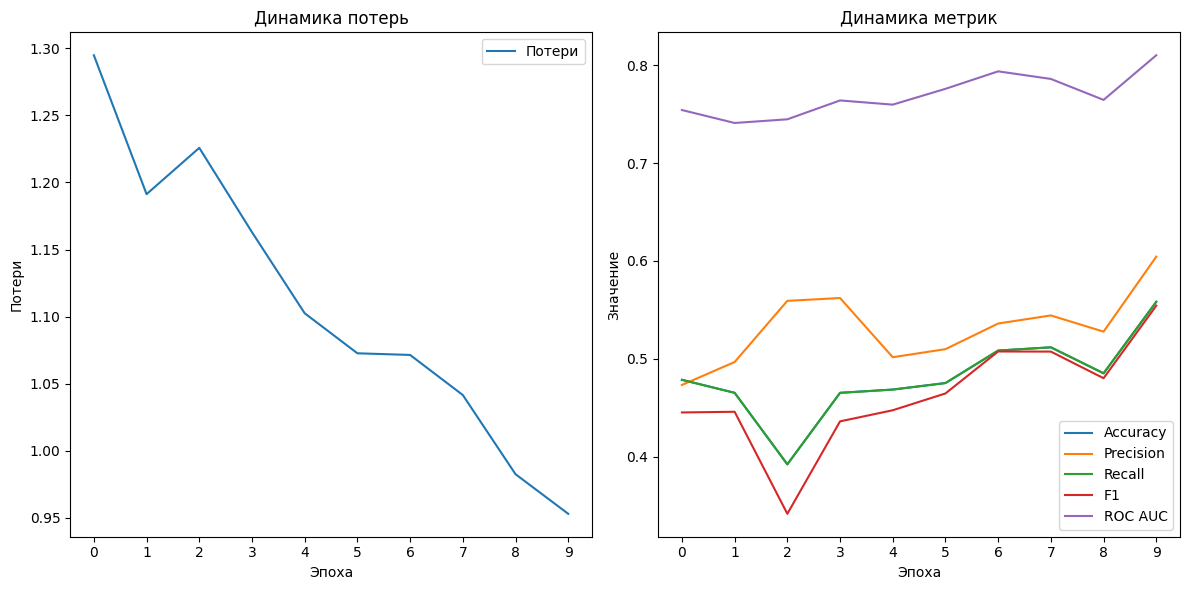

In [12]:
plot_history(history_transformer)

100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


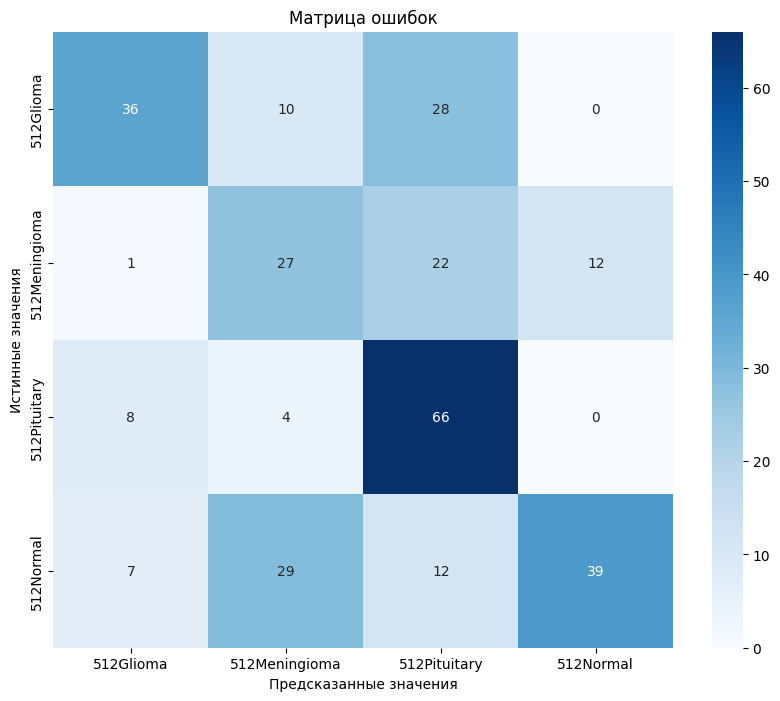

In [13]:
simple_transformer_metrics = evaluate_model(simple_transformer, test_loader)
with open('simple_transformer_metrics.pkl', 'wb') as f:
    pickle.dump(simple_transformer_metrics, f)
plot_confusion_matrix(simple_transformer_metrics['confusion_matrix'], classes)

## Сравнение с предобученными моделями

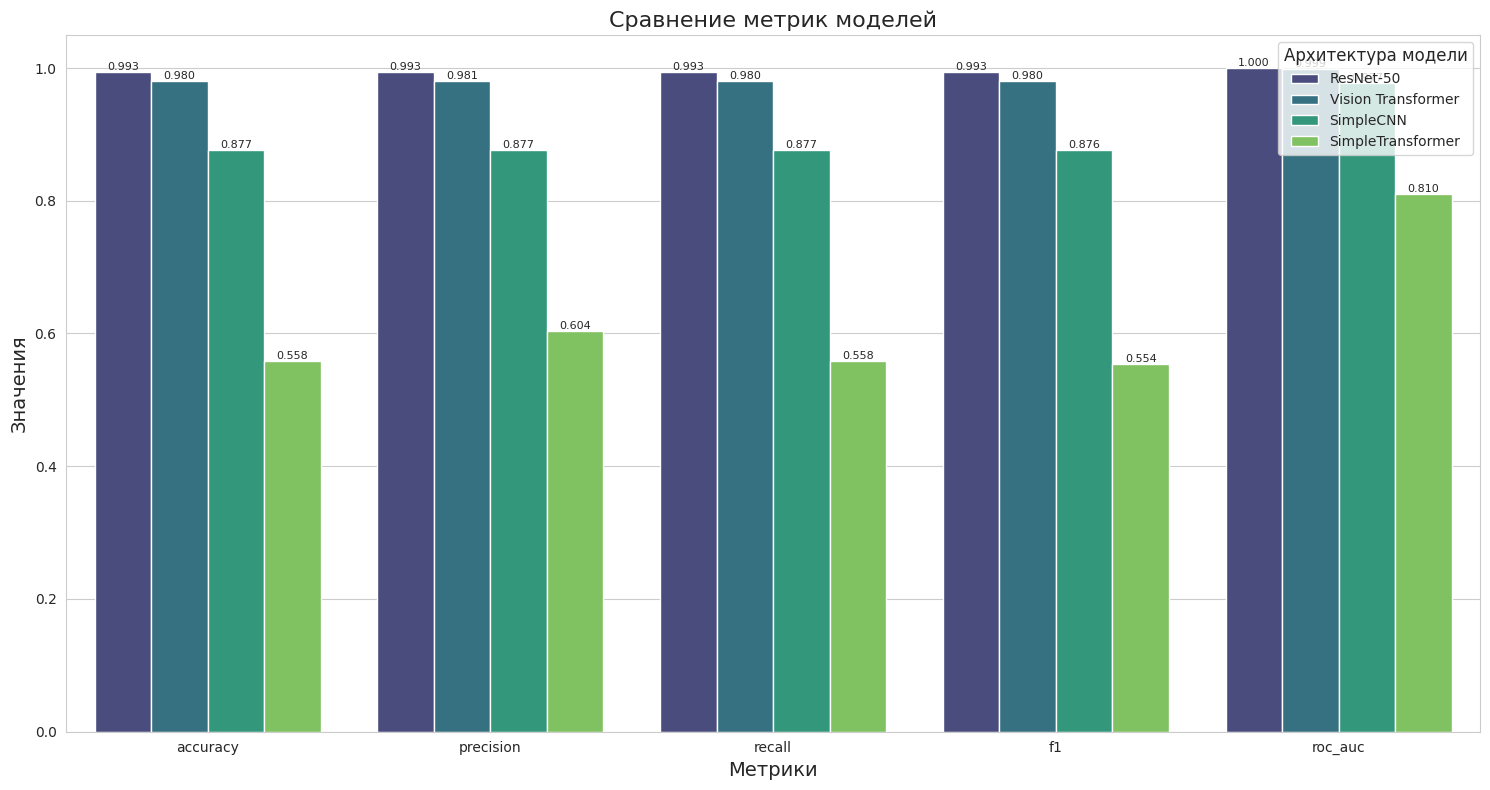

In [33]:

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
models_metrics = {
    'ResNet-50': resnet_metrics,
    'Vision Transformer': vit_metrics,
    'SimpleCNN': simple_cnn_metrics,
    'SimpleTransformer': simple_transformer_metrics
}

plot_model_metrics_comparison(metrics, models_metrics)

# Добавить техники из улучшенного бейзлайна

Добавление аугментаций

In [8]:
transform_augmented = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_augmented = BrainMRIDataset(dataset_dir, classes, transform=transform_augmented)
train_dataset_augmented, _ = torch.utils.data.random_split(dataset_augmented, [train_size, test_size])
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)

### Improved CNN

In [24]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [25]:
improved_cnn = ImprovedCNN(num_classes=len(classes))
improved_cnn.to(device)

optimizer_improved_cnn = optim.Adam(improved_cnn.parameters(), lr=0.0001, weight_decay=1e-5)

In [26]:
improved_cnn, history_improved_cnn = train_model(
    improved_cnn, 
    nn.CrossEntropyLoss(), 
    optimizer_improved_cnn, 
    train_loader_augmented, 
    test_loader, 
    num_epochs=10
)

Эпоха 1/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.42it/s]


Accuracy: 0.5449 | Precision: 0.7105 | Recall: 0.5449 | F1: 0.5397 | ROC AUC: 0.8791 | Потери: 1.2958
Сохранена новая лучшая модель с точностью: 0.5449
Эпоха 2/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.49it/s]


Accuracy: 0.7010 | Precision: 0.7862 | Recall: 0.7010 | F1: 0.7129 | ROC AUC: 0.9214 | Потери: 0.9753
Сохранена новая лучшая модель с точностью: 0.7010
Эпоха 3/10
----------


100%|██████████| 10/10 [00:01<00:00,  5.33it/s]


Accuracy: 0.6412 | Precision: 0.7419 | Recall: 0.6412 | F1: 0.6488 | ROC AUC: 0.9266 | Потери: 0.9009
Эпоха 4/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


Accuracy: 0.7575 | Precision: 0.8353 | Recall: 0.7575 | F1: 0.7632 | ROC AUC: 0.9524 | Потери: 0.7605
Сохранена новая лучшая модель с точностью: 0.7575
Эпоха 5/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.42it/s]


Accuracy: 0.8007 | Precision: 0.8364 | Recall: 0.8007 | F1: 0.8068 | ROC AUC: 0.9654 | Потери: 0.6209
Сохранена новая лучшая модель с точностью: 0.8007
Эпоха 6/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.45it/s]


Accuracy: 0.5980 | Precision: 0.7665 | Recall: 0.5980 | F1: 0.5728 | ROC AUC: 0.9505 | Потери: 0.5717
Эпоха 7/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.29it/s]


Accuracy: 0.8372 | Precision: 0.8477 | Recall: 0.8372 | F1: 0.8362 | ROC AUC: 0.9778 | Потери: 0.5259
Сохранена новая лучшая модель с точностью: 0.8372
Эпоха 8/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.31it/s]


Accuracy: 0.7841 | Precision: 0.8544 | Recall: 0.7841 | F1: 0.7862 | ROC AUC: 0.9771 | Потери: 0.5294
Эпоха 9/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.28it/s]


Accuracy: 0.9169 | Precision: 0.9267 | Recall: 0.9169 | F1: 0.9163 | ROC AUC: 0.9853 | Потери: 0.4365
Сохранена новая лучшая модель с точностью: 0.9169
Эпоха 10/10
----------


100%|██████████| 10/10 [00:01<00:00,  7.31it/s]

Accuracy: 0.7973 | Precision: 0.8600 | Recall: 0.7973 | F1: 0.8067 | ROC AUC: 0.9761 | Потери: 0.4231
Обучение завершено. Лучшая точность: 0.9169


In [28]:
with open('history_improved_cnn.pkl', 'wb') as f:
    pickle.dump(history_improved_cnn, f)

<Figure size 1200x600 with 0 Axes>

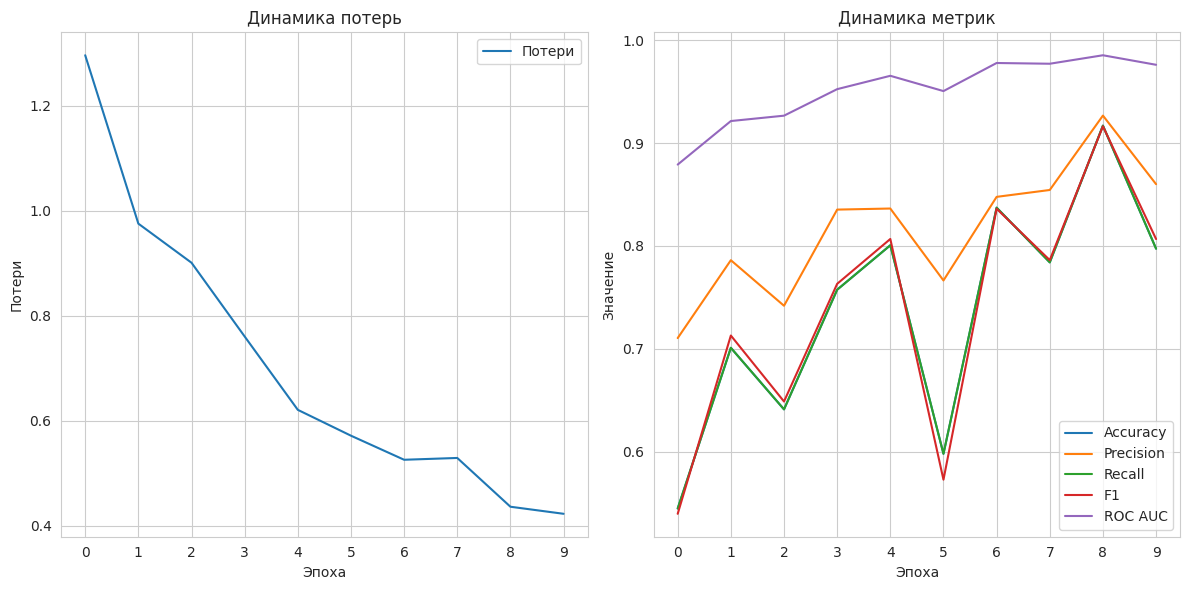

In [29]:
plot_history(history_improved_cnn)

100%|██████████| 10/10 [00:01<00:00,  7.61it/s]


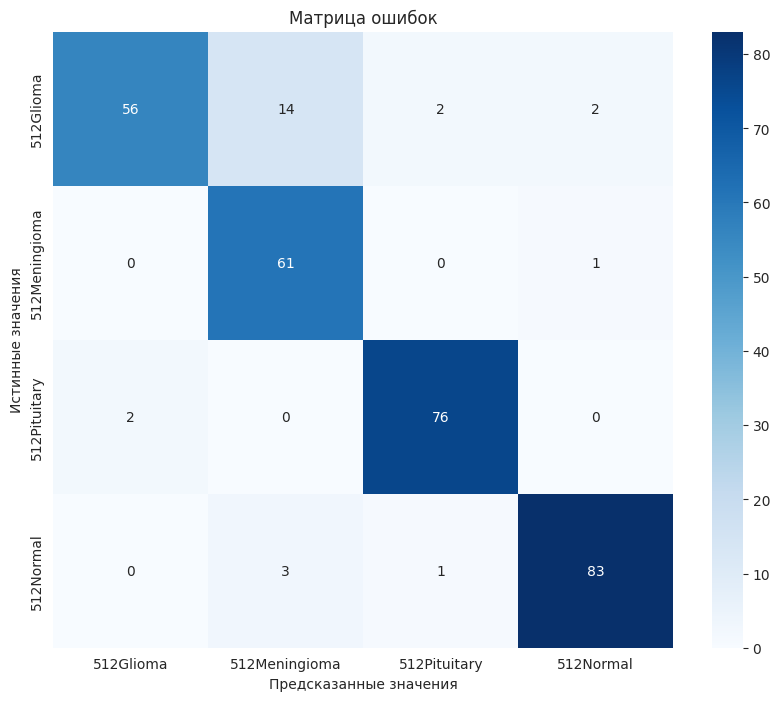

In [30]:
improved_cnn_metrics = evaluate_model(improved_cnn, test_loader)
with open('improved_cnn_metrics.pkl', 'wb') as f:
    pickle.dump(improved_cnn_metrics, f)
plot_confusion_matrix(improved_cnn_metrics['confusion_matrix'], classes)

### ImprovedTransformer

In [9]:
class ImprovedTransformer(nn.Module):
    def __init__(self, num_classes=4, img_size=224, patch_size=16, embed_dim=256, num_heads=8, num_layers=4, dropout=0.3):
        super(ImprovedTransformer, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, embed_dim // 4, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(embed_dim // 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(embed_dim // 4, embed_dim // 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(embed_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(embed_dim // 2, embed_dim, kernel_size=patch_size // 2, stride=patch_size // 2),
            nn.BatchNorm2d(embed_dim)
        )
        
        feature_size = img_size // 2
        num_patches = (feature_size // (patch_size // 2)) ** 2
        
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_embed_scale = nn.Parameter(torch.ones(1))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(p=dropout)
        
        encoder_layers = []
        for _ in range(num_layers):
            encoder_layers.append(
                ImprovedTransformerBlock(
                    dim=embed_dim,
                    num_heads=num_heads,
                    mlp_ratio=4.0,
                    dropout=dropout
                )
            )
        self.transformer_blocks = nn.ModuleList(encoder_layers)
        
        self.norm = nn.LayerNorm(embed_dim)
        
        self.head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_classes)
        )
        
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        x = self.feature_extractor(x)
        
        B, E, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        
        x = x + self.pos_embed * self.pos_embed_scale
        x = self.pos_drop(x)
        
        for block in self.transformer_blocks:
            x = block(x)
        
        x = self.norm(x[:, 0])
        x = self.head(x)
        
        return x

class ImprovedTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.drop_path = nn.Dropout(dropout)
        
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(dropout)
        )
        
        self.gamma1 = nn.Parameter(torch.ones(dim))
        self.gamma2 = nn.Parameter(torch.ones(dim))
        
    def forward(self, x):
        x_norm = self.norm1(x)
        attn_output, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + self.drop_path(attn_output) * self.gamma1
        
        x_norm = self.norm2(x)
        mlp_output = self.mlp(x_norm)
        x = x + self.drop_path(mlp_output) * self.gamma2
        
        return x

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
improved_transformer = ImprovedTransformer(num_classes=len(classes), embed_dim=256, num_heads=32, num_layers=24)

improved_transformer.to(device)
optimizer_improved_transformer = optim.Adam(improved_transformer.parameters(), lr=0.0001)

In [16]:
improved_transformer, history_improved_transformer = train_model(
    improved_transformer, 
    nn.CrossEntropyLoss(), 
    optimizer_improved_transformer,
    train_loader_augmented,
    test_loader,
    num_epochs=10
)

Эпоха 1/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Accuracy: 0.3854 | Precision: 0.5268 | Recall: 0.3854 | F1: 0.3510 | ROC AUC: 0.7603 | Потери: 1.3210
Сохранена новая лучшая модель с точностью: 0.3854
Эпоха 2/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Accuracy: 0.5415 | Precision: 0.5792 | Recall: 0.5415 | F1: 0.5065 | ROC AUC: 0.7963 | Потери: 1.2371
Сохранена новая лучшая модель с точностью: 0.5415
Эпоха 3/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Accuracy: 0.5050 | Precision: 0.6164 | Recall: 0.5050 | F1: 0.4413 | ROC AUC: 0.7850 | Потери: 1.1618
Эпоха 4/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Accuracy: 0.6047 | Precision: 0.6279 | Recall: 0.6047 | F1: 0.6054 | ROC AUC: 0.8365 | Потери: 1.0870
Сохранена новая лучшая модель с точностью: 0.6047
Эпоха 5/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Accuracy: 0.4219 | Precision: 0.5438 | Recall: 0.4219 | F1: 0.3794 | ROC AUC: 0.8233 | Потери: 1.0227
Эпоха 6/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Accuracy: 0.5880 | Precision: 0.6374 | Recall: 0.5880 | F1: 0.5502 | ROC AUC: 0.8163 | Потери: 0.9510
Эпоха 7/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Accuracy: 0.5216 | Precision: 0.6642 | Recall: 0.5216 | F1: 0.4870 | ROC AUC: 0.8070 | Потери: 0.9335
Эпоха 8/10
----------


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.2857 | Precision: 0.0816 | Recall: 0.2857 | F1: 0.1270 | ROC AUC: 0.6748 | Потери: 0.8869
Эпоха 9/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Accuracy: 0.5947 | Precision: 0.7685 | Recall: 0.5947 | F1: 0.5802 | ROC AUC: 0.8936 | Потери: 0.8817
Эпоха 10/10
----------


100%|██████████| 10/10 [00:02<00:00,  3.42it/s]

Accuracy: 0.6412 | Precision: 0.7697 | Recall: 0.6412 | F1: 0.6422 | ROC AUC: 0.9036 | Потери: 0.8435
Сохранена новая лучшая модель с точностью: 0.6412
Обучение завершено. Лучшая точность: 0.6412


In [17]:
with open('history_improved_transformer.pkl', 'wb') as f:
    pickle.dump(history_improved_transformer, f)

<Figure size 1200x600 with 0 Axes>

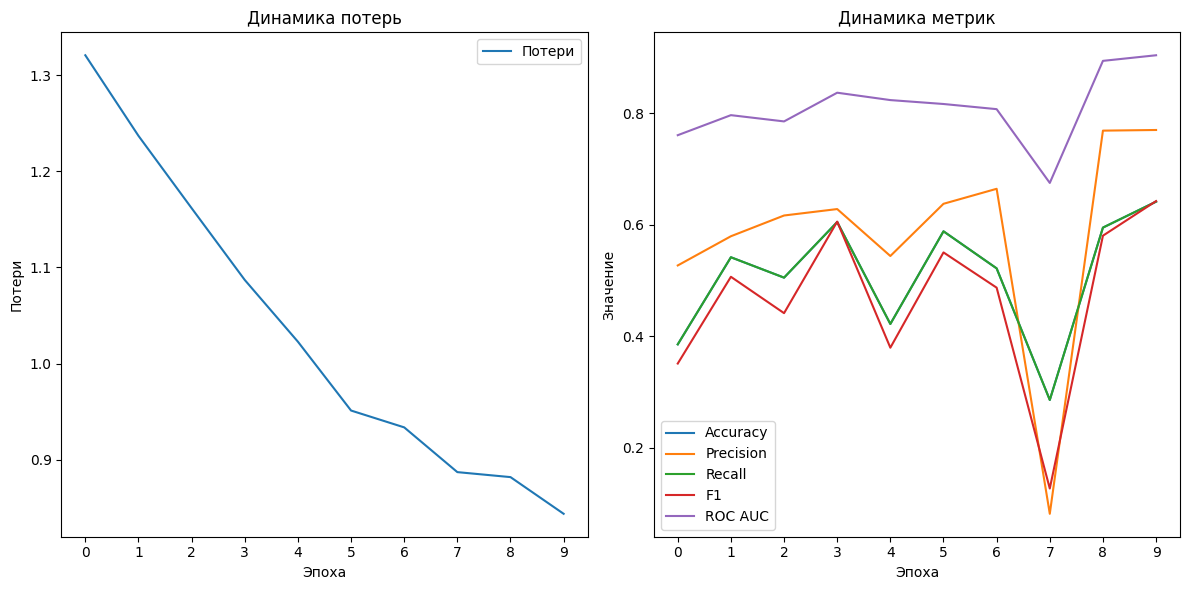

In [18]:
plot_history(history_improved_transformer)

100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


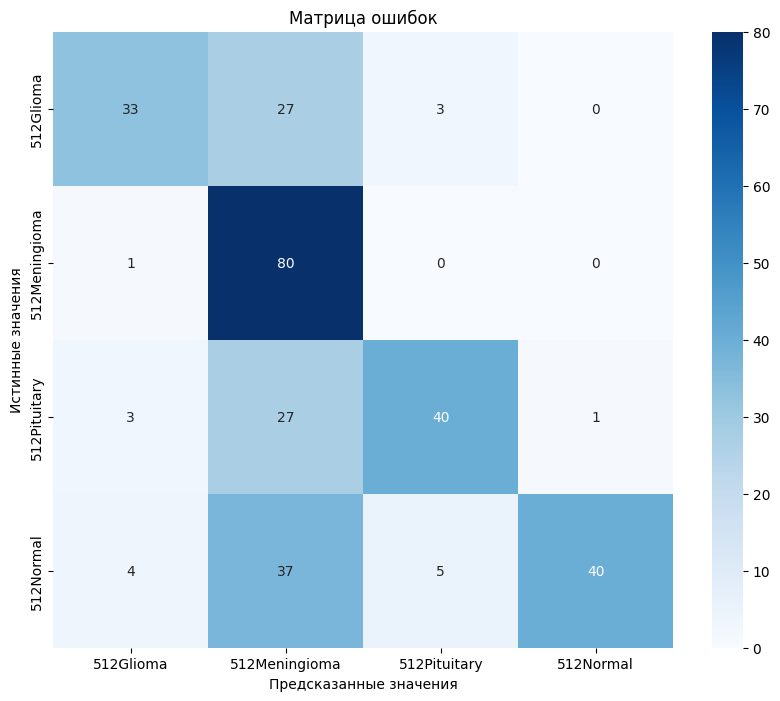

In [19]:
improved_transformer_metrics = evaluate_model(improved_transformer, test_loader)
with open('improved_transformer_metrics.pkl', 'wb') as f:
    pickle.dump(improved_transformer_metrics, f)
plot_confusion_matrix(improved_transformer_metrics['confusion_matrix'], classes)

## Сравнение

Сравнение с предобученными моделями

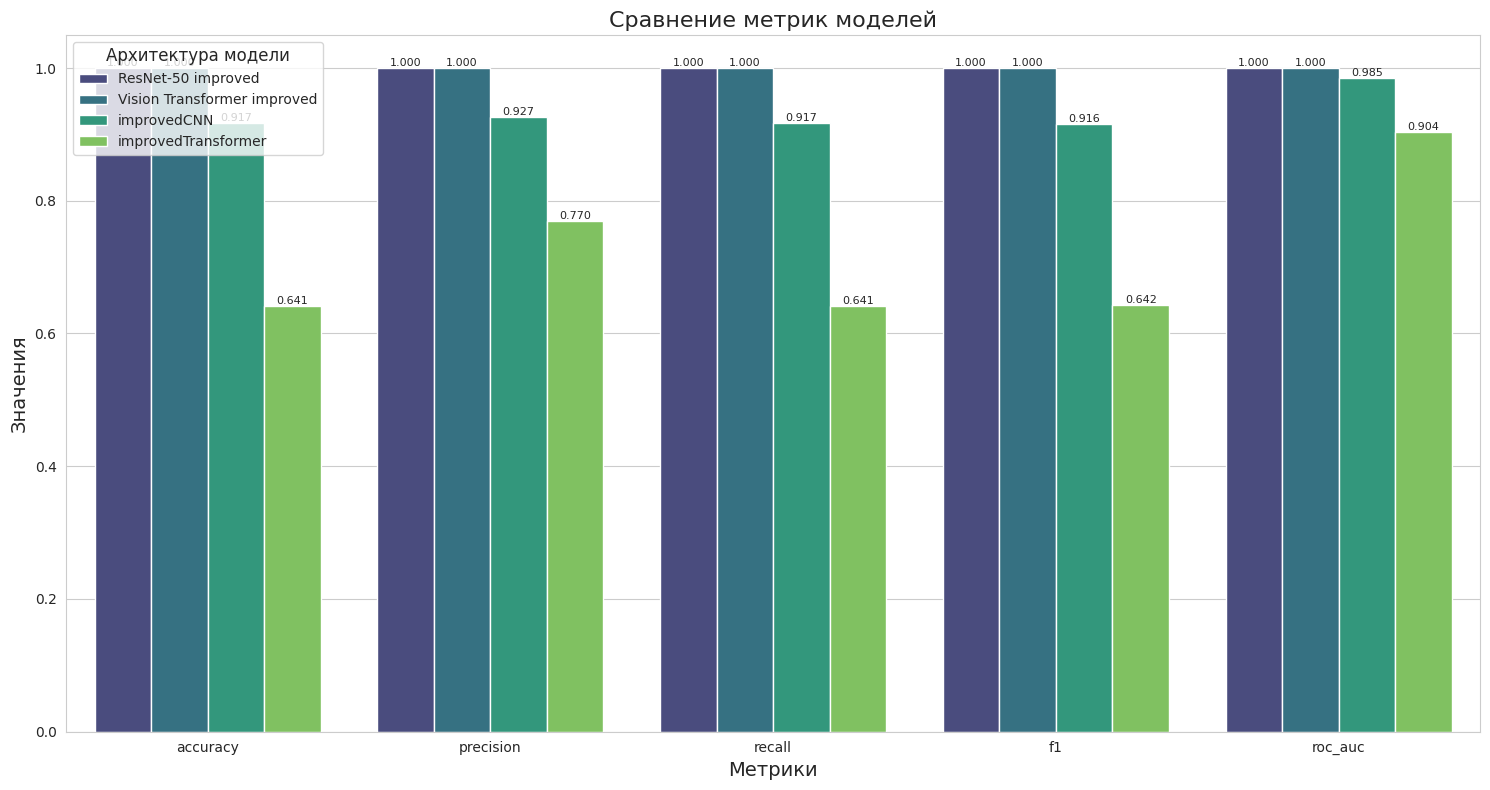

In [31]:

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
models_metrics = {
    'ResNet-50 improved': resnet_improved_metrics,
    'Vision Transformer improved': vit_improved_metrics,
    'improvedCNN': improved_cnn_metrics,
    'improvedTransformer': improved_transformer_metrics
}

plot_model_metrics_comparison(metrics, models_metrics)

Сравнение байзлайнов с улучшенными моделями

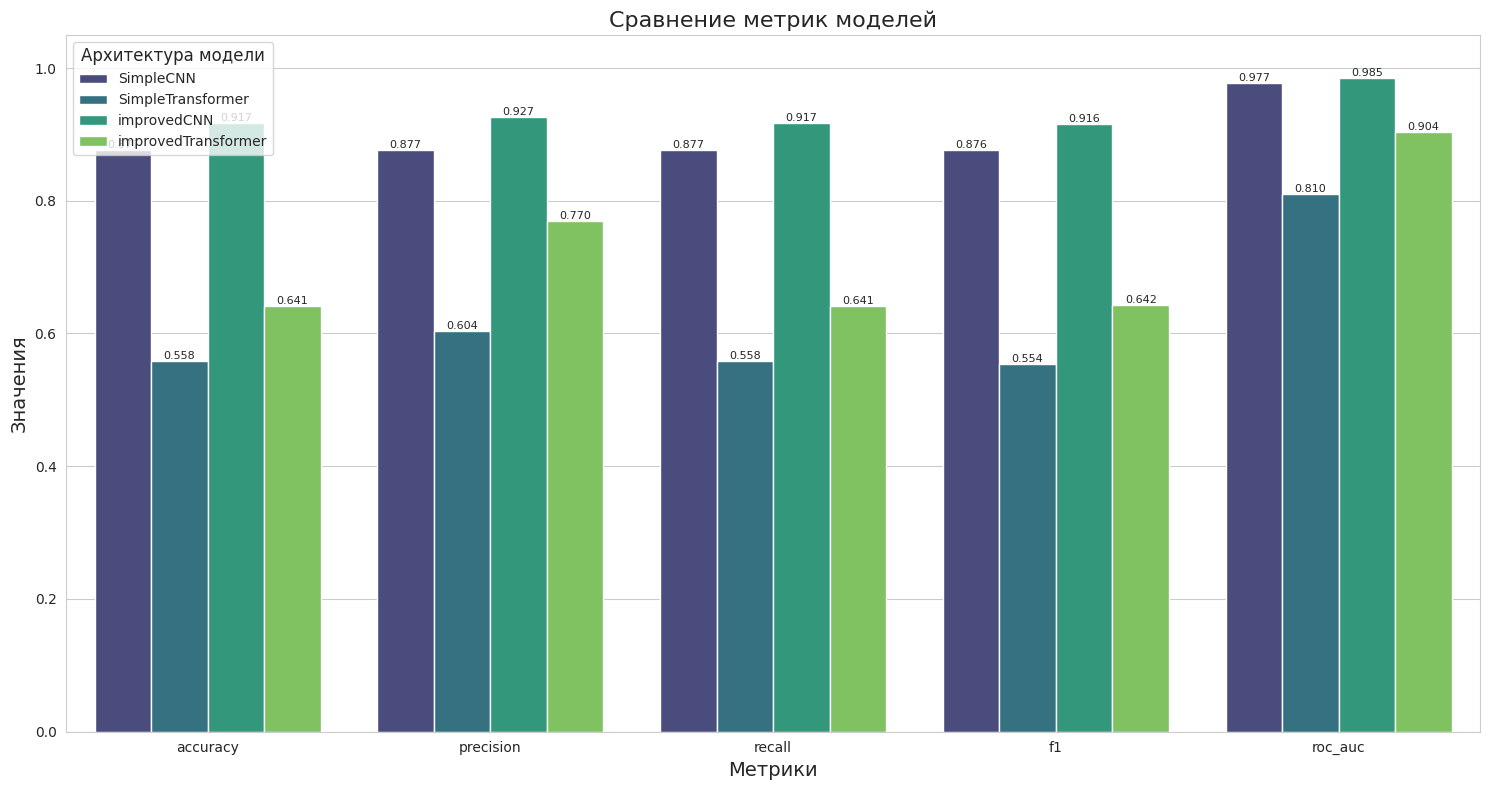

In [32]:

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
models_metrics = {
    'SimpleCNN': simple_cnn_metrics,
    'SimpleTransformer': simple_transformer_metrics,
    'improvedCNN': improved_cnn_metrics,
    'improvedTransformer': improved_transformer_metrics
}

plot_model_metrics_comparison(metrics, models_metrics)

# Выводы по результатам имплементации собственных моделей:
1. Собственная реализация CNN показала хорошие результаты, но значительно уступает предобученным моделям
2. Собственная трансформерная модель показала наихудшие результаты
3. Улучшенная CNN с добавлением BatchNorm, дополнительных слоев и аугментаций данных значительно улучшила результаты
4. Техники регуляризации (dropout, weight decay) помогли достичь лучшей сходимости
5. Наилучшие результаты по-прежнему показывает ResNet-50 Modified и Vision Transformer Modified, но улучшенная CNN приближается к его показателям
